# Data preparation

Questo jnb rappresenta una prima esplorazione dei dati a disposizione, insieme al tenativo di pre-processarli con diverse tecniche di signal processing mutuate da diverse fonti (in particolare: https://bit.ly/2zQEeIg). I dati sono riorganizzati poi in una struttura consona per l'addestramento di un classificatore.

In [1]:
import os
import sys
import glob

import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [3]:
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.signal import welch
from scipy.signal import butter
from scipy.signal import filtfilt

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [6]:
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

## 1. EDA Exploratory Data Analysis

#### 1.1. EDA singolo file

In [7]:
# importa un singolo file in un Dataframe di pandas
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
df = pd.read_csv(data_path + file_name, delimiter=',', header=None)

In [8]:
df.head()

0     1      2     3     4
0  20180920-15:24:10.452 -7464  16632  2060  2111
1  20180920-15:24:10.456  3976  17892 -6080  2115
2  20180920-15:24:10.458  -584  17500  1356  2124
3  20180920-15:24:10.460  -584  17500  1356  2142
4  20180920-15:24:10.462  -584  17500  1356  2143

In [9]:
# rinomina le feature del df
df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)

In [10]:
# trasforma il tipo della feature "date_time" nel formato date_time
df['date_time'] = pd.to_datetime(df['date_time'])

In [11]:
df.shape

(25575, 5)

In [12]:
df.head(10), df.tail(10)

(                date_time     x      y     z     i
 0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
 1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
 2 2018-09-20 15:24:10.458  -584  17500  1356  2124
 3 2018-09-20 15:24:10.460  -584  17500  1356  2142
 4 2018-09-20 15:24:10.462  -584  17500  1356  2143
 5 2018-09-20 15:24:10.465   552  12740 -1860  2132
 6 2018-09-20 15:24:10.467   552  12740 -1860  2144
 7 2018-09-20 15:24:10.469 -7728  17280  1608  2133
 8 2018-09-20 15:24:10.471 -7728  17280  1608  2115
 9 2018-09-20 15:24:10.473  4628  17392 -6220  2097,
                     date_time     x      y     z     i
 25565 2018-09-20 15:25:11.984   224  16732   596  2217
 25566 2018-09-20 15:25:11.986 -3604  13988  1136  1975
 25567 2018-09-20 15:25:11.988 -3604  13988  1136  1807
 25568 2018-09-20 15:25:11.990  -980  17712 -3740  1760
 25569 2018-09-20 15:25:11.993  -980  17712 -3740  1937
 25570 2018-09-20 15:25:11.995  1148  16772 -2528  2176
 25571 2018-09-20 15:25:11.997  114

Plottiamo le time series delle singole variabili misurate in un intervallo a scelta.

In [13]:
df.columns.values

array(['date_time', 'x', 'y', 'z', 'i'], dtype=object)

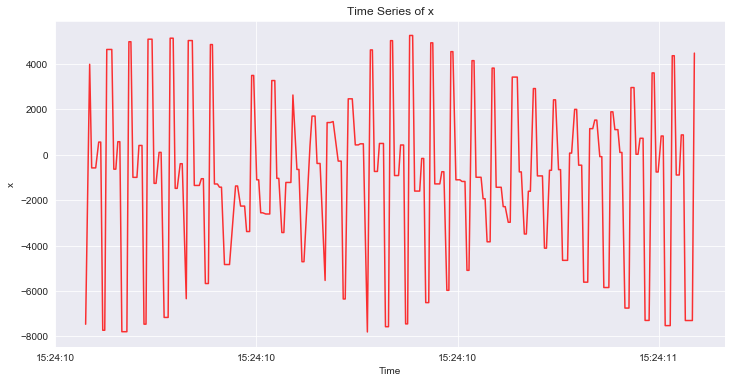

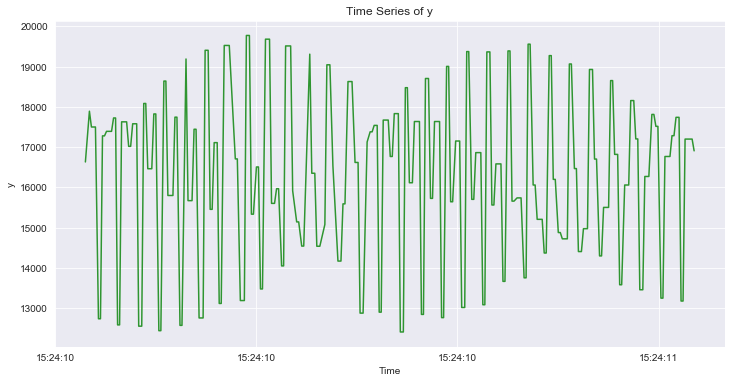

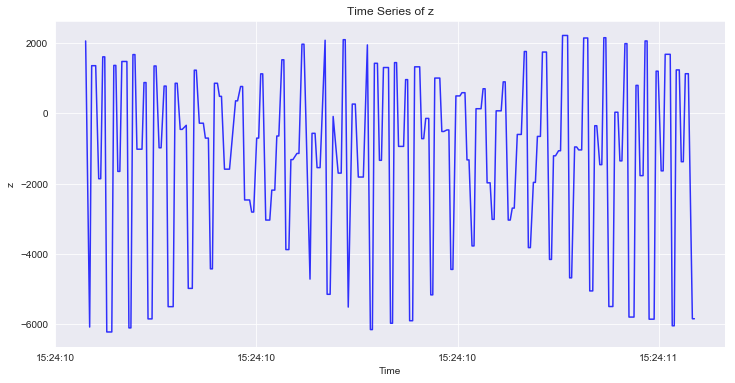

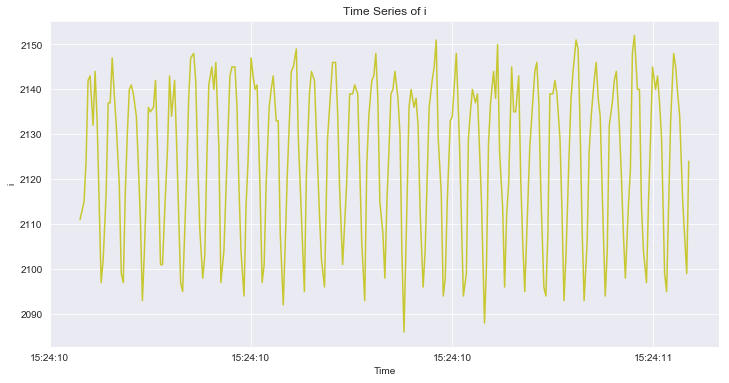

In [14]:
start_time = 0
end_time = 256
variables = df.columns.values[1:]
colors = {'x':'r', 'y':'g', 'z':'b', 'i':'y'}

for var in variables:
    
    plt.figure(figsize=(12,6))
    sns.lineplot(x='date_time', y=var, data=df[start_time:end_time], color=colors[var], alpha=0.8)
    plt.title("Time Series of " + var)
    plt.xlabel("Time")
    plt.ylabel(var)

Plottiamo la distribuzione delle singole variabili.

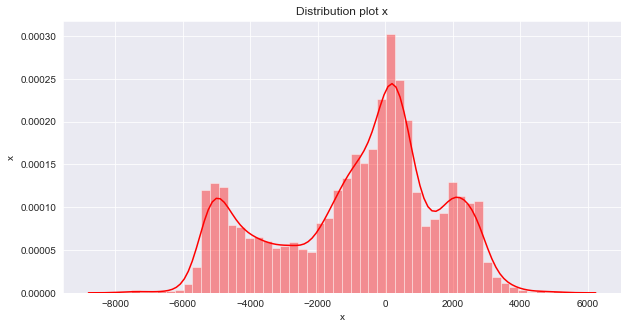

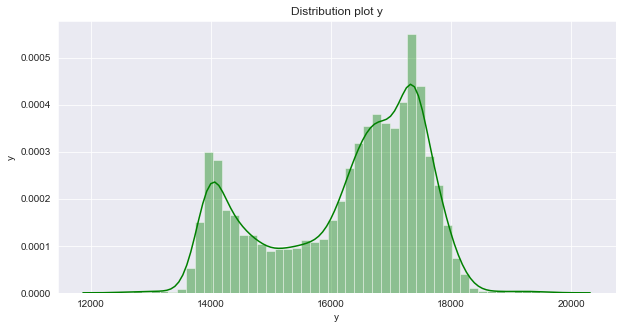

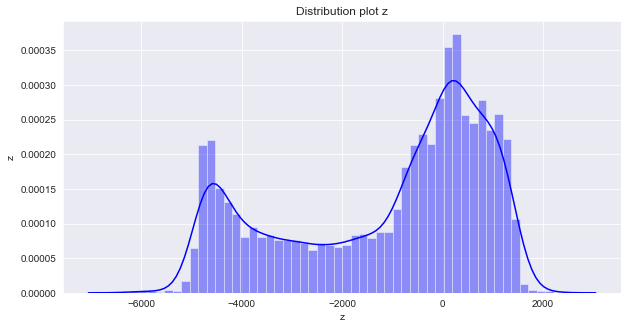

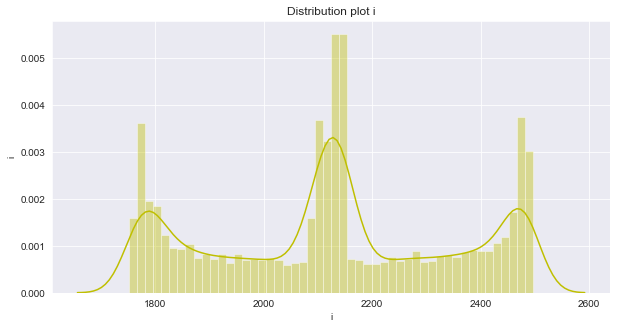

In [15]:
for var in variables:
    
    plt.figure(figsize=(10,5))
    sns.distplot(df[var], bins=50, color=colors[var], norm_hist=True)
    plt.title("Distribution plot " + var)
    plt.xlabel(var)
    plt.ylabel(var)

#### 1.2. EDA tutti i file

In [16]:
"""
importa tutti i file dei dati .csv, li etichetta
e li concatena in un unico dataframe
"""

all_files = glob.glob(data_path + "/*.csv")
all_files.sort()

dframe = pd.DataFrame()
f_list = []

for f in all_files:
    
    # skippa i campioni iniziali
    df = pd.read_csv(f, skiprows=1024, delimiter=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    # assegna la label a ciascun sub-dataframe
    df['label'] = f[f.rfind('\\') +1]
    f_list.append(df)
    
# concatena i singoli df
dframe = pd.concat(f_list)

In [17]:
dframe.head(), dframe.tail()

(                date_time     x      y     z     i label
 0 2018-09-20 15:30:44.194 -3888  13068 -4300  2144     1
 1 2018-09-20 15:30:44.196  -112  15828 -4300  2136     1
 2 2018-09-20 15:30:44.199  -112  15828 -4300  2138     1
 3 2018-09-20 15:30:44.201 -7380  18088  3936  2122     1
 4 2018-09-20 15:30:44.203 -7380  18088  3936  2102     1,
                     date_time     x      y    z     i label
 24547 2018-09-20 15:28:58.065  1012  16352   28  2468     7
 24548 2018-09-20 15:28:58.067  1012  16352   28  2480     7
 24549 2018-09-20 15:28:58.069  1012  15024  780  2294     7
 24550 2018-09-20 15:28:58.071 -2012  15024  780  2070     7
 24551 2018-09-20 15:28:58.074 -2012  15024  780  1838     7)

In [18]:
# elenca il numero di sample per classe dalla più numerosa
dframe.label.value_counts()

5    50127
7    24552
2    24552
6    14322
4     9207
1     9207
3     9207
Name: label, dtype: int64

([<matplotlib.axis.XTick at 0x15c173e8eb8>,
 <a list of 7 Text xticklabel objects>)

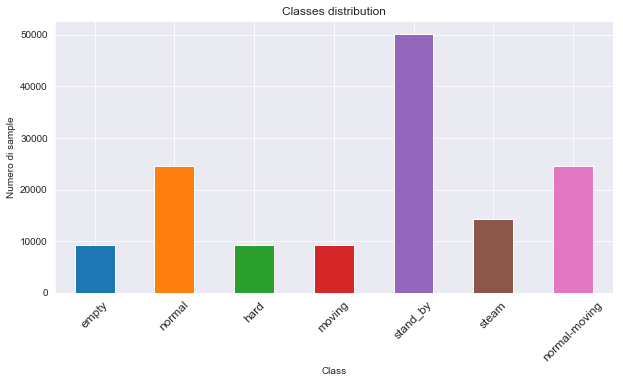

In [19]:
# plotta la distribuzione delle classi (numero di campioni per classe = modalità di funzionamento)
count_classes = pd.value_counts(dframe['label'], sort = True).sort_index()
plt.figure(figsize=(10,5))
count_classes.plot(kind = 'bar')
plt.title("Classes distribution")
plt.xlabel("Class")
plt.ylabel("Numero di sample")
#labels = {'1':'empty', '2':'normal', '3':'hard', '4':'moving', '5':'stand_by', '6':'steam', '7':'normal-moving'}
labels = ['empty', 'normal', 'hard', 'moving', 'stand_by', 'steam', 'normal-moving']
plt.xticks(range(0,7), labels, rotation=45, fontsize=12)

In [20]:
# prende la norma delle componenti del segnale lungo i tre assi
dframe['m'] = np.sqrt(dframe['x']**2 + dframe['y']**2 + dframe['z']**2)

In [21]:
dframe.head()

date_time     x      y     z     i label             m
0 2018-09-20 15:30:44.194 -3888  13068 -4300  2144     1  14296.124230
1 2018-09-20 15:30:44.196  -112  15828 -4300  2136     1  16402.076942
2 2018-09-20 15:30:44.199  -112  15828 -4300  2138     1  16402.076942
3 2018-09-20 15:30:44.201 -7380  18088  3936  2122     1  19928.177037
4 2018-09-20 15:30:44.203 -7380  18088  3936  2102     1  19928.177037

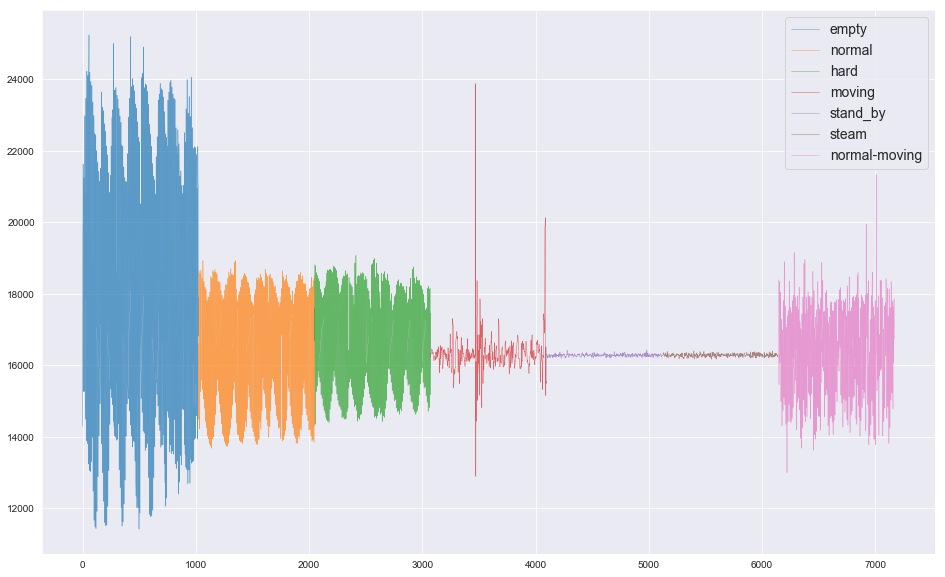

In [22]:
# plotta un certo numero di campioni per ogni modalità di funzionamento
# per visualizzare le forme d'onda 
start_sample = 0
end_sample = 1024

plt.figure(figsize=(16,10))

for c in range(1, 8):
    plt.plot(dframe[dframe['label'] == str(c)]['m'][start_sample:end_sample], 
             linewidth=.5, alpha=0.70)
    start_sample = end_sample
    end_sample = start_sample + 1024

plt.legend(labels, prop={'size': 14})

Visualizziamo le correlazioni tra le variabili x, y, z, raggruppate per label.

In [23]:
# ignora l'errore di divisione per zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [24]:
# genera il df per la visualizzazione a coppie
pair_df = dframe.loc[:, ['x','y','z','label']]

In [25]:
labels_dict = {'1':'empty', '2':'normal', '3':'hard', '4':'moving', '5':'stand_by', '6':'steam', '7':'normal-moving'}

In [26]:
pair_df['label'] = pair_df['label'].map(labels_dict)

In [27]:
pair_df.head()

x      y     z  label
0 -3888  13068 -4300  empty
1  -112  15828 -4300  empty
2  -112  15828 -4300  empty
3 -7380  18088  3936  empty
4 -7380  18088  3936  empty

In [28]:
col_labels_dict = {'empty':'C0', 'normal':'C1', 'hard':'C2', 'moving':'C3', 'stand_by':'C4',
              'steam':'C5', 'normal-moving':'C6'}

In [29]:
# seleziona le label per il pair plot in base a labels_dict
sel_labels = [1, 2, 3]
hue_order = [labels_dict[str(i)] for i in sel_labels]

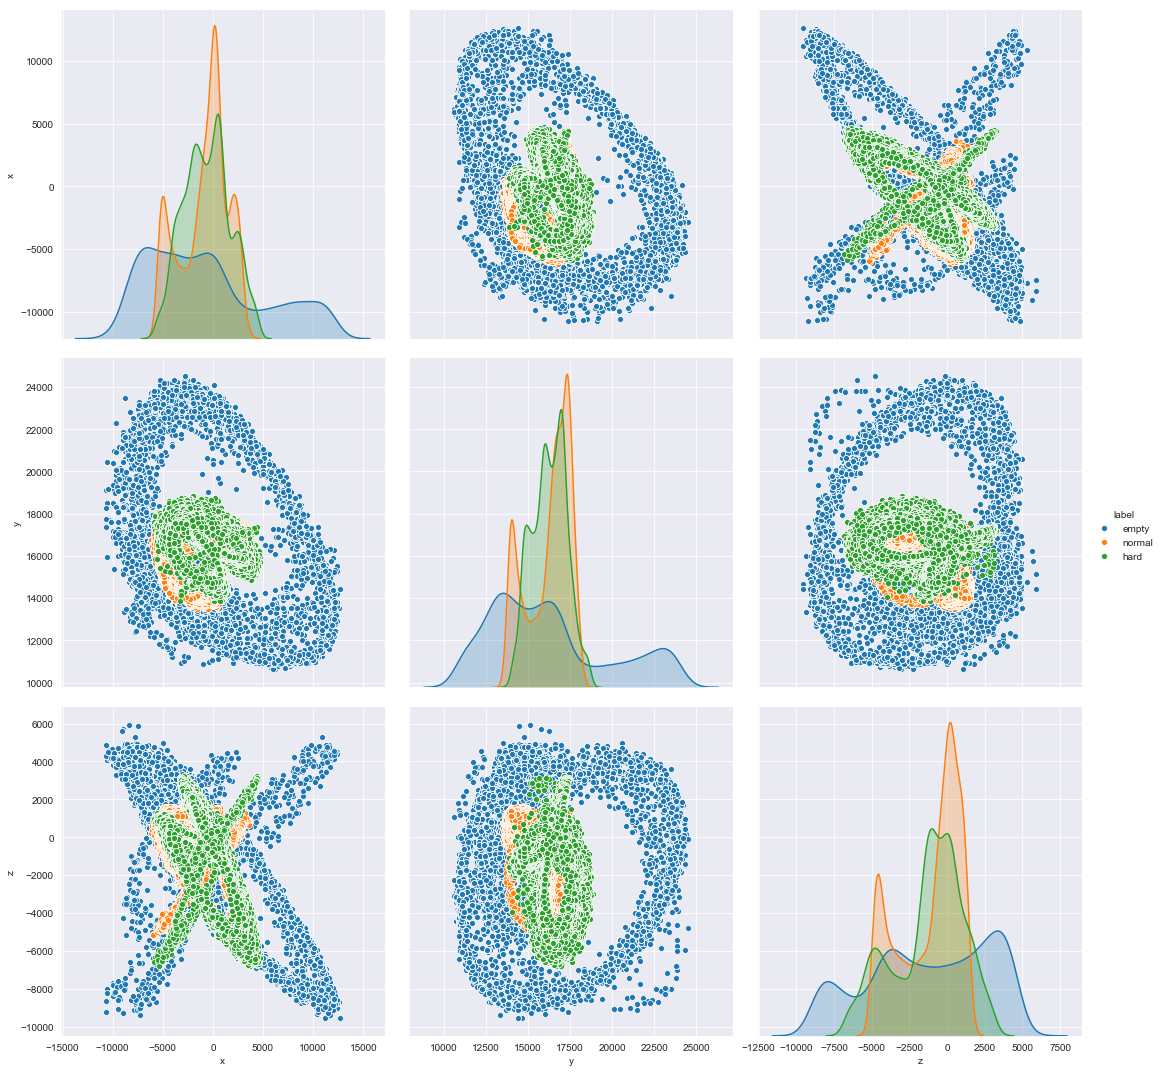

In [30]:
# rispetto alle prime tre label: empty, normal pouring, hard pouring
g = sns.pairplot(pair_df, vars=['x','y','z'], hue="label", hue_order=hue_order,
                 height=5, palette=col_labels_dict)

In [31]:
# seleziona le label per il pair plot in base a labels_dict
sel_labels = [3, 4, 7]
hue_order = [labels_dict[str(i)] for i in sel_labels]

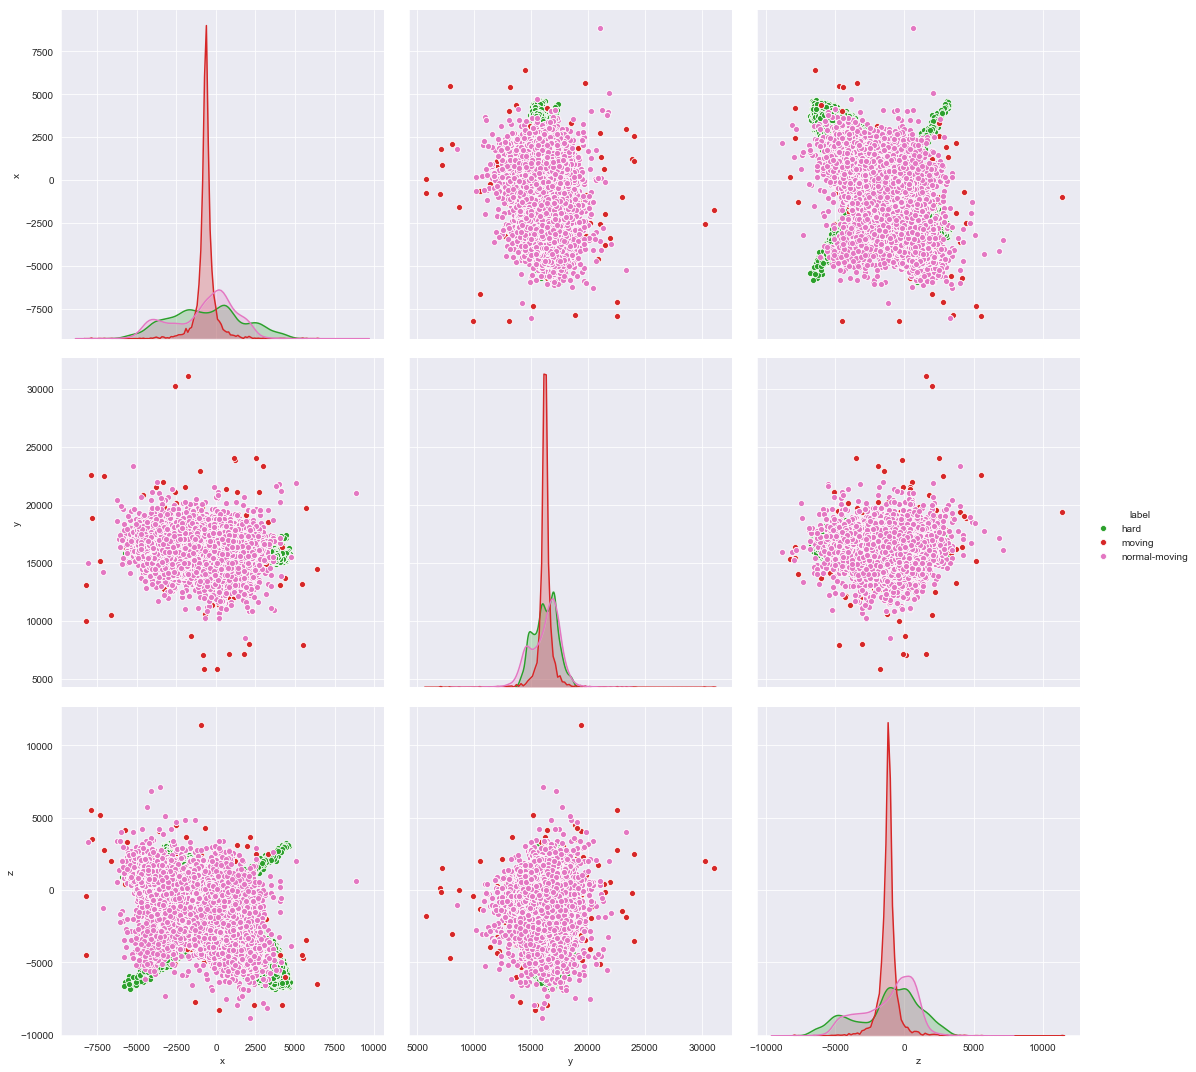

In [32]:
# rispetto alle label: hard pouring, moving, normal-moving
g = sns.pairplot(pair_df, vars=['x','y','z'], hue="label", hue_order=hue_order,
                 height=5, palette=col_labels_dict)

## 2. Pre-processing

### 2.1. Pre-processing FFT

Calcoliamo la FFT per il **singolo file.**

In [33]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [34]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

In [35]:
df = pd.read_csv(data_path + file_name, delimiter=',', header=None)

In [36]:
df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)

In [37]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [38]:
df.head(10), df.tail(10)

(                date_time     x      y     z     i
 0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
 1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
 2 2018-09-20 15:24:10.458  -584  17500  1356  2124
 3 2018-09-20 15:24:10.460  -584  17500  1356  2142
 4 2018-09-20 15:24:10.462  -584  17500  1356  2143
 5 2018-09-20 15:24:10.465   552  12740 -1860  2132
 6 2018-09-20 15:24:10.467   552  12740 -1860  2144
 7 2018-09-20 15:24:10.469 -7728  17280  1608  2133
 8 2018-09-20 15:24:10.471 -7728  17280  1608  2115
 9 2018-09-20 15:24:10.473  4628  17392 -6220  2097,
                     date_time     x      y     z     i
 25565 2018-09-20 15:25:11.984   224  16732   596  2217
 25566 2018-09-20 15:25:11.986 -3604  13988  1136  1975
 25567 2018-09-20 15:25:11.988 -3604  13988  1136  1807
 25568 2018-09-20 15:25:11.990  -980  17712 -3740  1760
 25569 2018-09-20 15:25:11.993  -980  17712 -3740  1937
 25570 2018-09-20 15:25:11.995  1148  16772 -2528  2176
 25571 2018-09-20 15:25:11.997  114

In [39]:
def get_signal_properties(df, start_time_idx, end_time_idx):
    
    """
    calcola alcune proprietà del segnale campionato
    
    parametri:
    ----------
    df : pandas dataframe contenente una colonna di tipo datetime
    start_time_idx = indice del primo istante della finestra temporale (campione)
    end_time_idx = indice dell'utlimo istante temporale
    
    return:
    -------
    N : numero di campioni
    delta_time_sec : durata in secondi dell'intervallo di campionamento
    T : periodo = delta_time_sec/N
    fs : frequenza di campionamento = 1/T   
    
    """
    
    df = df.reset_index()
    df = df[start_time_idx:end_time_idx]
    delta_time_sec = (df['date_time'][end_time_idx - 1] - df['date_time'][start_time_idx]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    fs = round(1/T, 2)
    
    return N, delta_time_sec, T, fs

In [40]:
N, delta_time_sec, T, fs = get_signal_properties(df, start_time_idx=0, end_time_idx=128)

In [41]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.313 secondi
Il periodo è: 0.0024 secondi
La frequenza di campionamento è: 408.95 Hz


In [42]:
N, delta_time_sec, T, fs = get_signal_properties(df, start_time_idx=128, end_time_idx=256)

In [43]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(T))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.289 secondi
Il periodo è: 0.0022578125 secondi
La frequenza di campionamento è: 442.91 Hz


Come si può osservare, il segnale è campionato in modo irregolare. Per regolarizzarlo è necessario ricampionarlo

In [44]:
df.head()

date_time     x      y     z     i
0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
2 2018-09-20 15:24:10.458  -584  17500  1356  2124
3 2018-09-20 15:24:10.460  -584  17500  1356  2142
4 2018-09-20 15:24:10.462  -584  17500  1356  2143

In [45]:
df_tmp = df.set_index('date_time')

In [46]:
df_tmp.head()

x      y     z     i
date_time                                       
2018-09-20 15:24:10.452 -7464  16632  2060  2111
2018-09-20 15:24:10.456  3976  17892 -6080  2115
2018-09-20 15:24:10.458  -584  17500  1356  2124
2018-09-20 15:24:10.460  -584  17500  1356  2142
2018-09-20 15:24:10.462  -584  17500  1356  2143

Scegliamo un intervallo di 3 ms per non discostarci troppo dal range di frequenze del campionamento originale. In ogni caso possiamo scegliere un diverso intervallo temporale.

In [47]:
delta_ms = '3ms'

In [48]:
df_res = df_tmp.resample(delta_ms).asfreq().interpolate().dropna()

In [49]:
# verifica che non ci siano NaN nel segnale ricampionato
df_res.isna().sum()

x    0
y    0
z    0
i    0
dtype: int64

In [50]:
# ritorna alla precedente struttura del df
df_res = df_res.reset_index()

In [51]:
df_res.head(10)

date_time            x             y       z            i
0 2018-09-20 15:24:10.452 -7464.000000  16632.000000  2060.0  2111.000000
1 2018-09-20 15:24:10.455 -4024.000000  17066.000000  1708.0  2117.500000
2 2018-09-20 15:24:10.458  -584.000000  17500.000000  1356.0  2124.000000
3 2018-09-20 15:24:10.461  -205.333333  15913.333333   284.0  2130.666667
4 2018-09-20 15:24:10.464   173.333333  14326.666667  -788.0  2137.333333
5 2018-09-20 15:24:10.467   552.000000  12740.000000 -1860.0  2144.000000
6 2018-09-20 15:24:10.470  2590.000000  15066.000000 -4040.0  2120.500000
7 2018-09-20 15:24:10.473  4628.000000  17392.000000 -6220.0  2097.000000
8 2018-09-20 15:24:10.476  2872.000000  17502.666667 -3692.0  2110.333333
9 2018-09-20 15:24:10.479  1116.000000  17613.333333 -1164.0  2123.666667

Verifichiamo che il segnale ricampionato sia regolare prendendo diverse finestre (buffer) dello stesso numero di sample.

In [52]:
N, delta_time_sec, T, fs = get_signal_properties(df_res, start_time_idx=0, end_time_idx=128)

In [53]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [54]:
N, delta_time_sec, T, fs = get_signal_properties(df_res, start_time_idx=256, end_time_idx=384)

In [55]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


Applichiamo la trasformata veloce di Fourier per analizzare le componenti periodiche del segnale.

In [56]:
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [57]:
f_values.size

64

In [58]:
fft_values_ = fft(df_res['x'])
fft_values = 2.0/N * np.abs(fft_values_[0:N//2])

In [59]:
fft_values.size

64

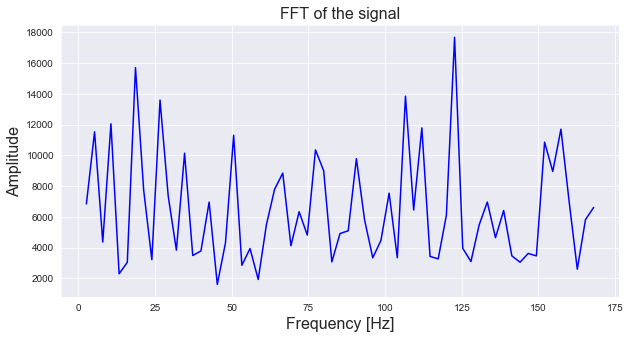

In [60]:
plt.figure(figsize=(10,5))
plt.plot(f_values[1:], fft_values[1:], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT of the signal", fontsize=16)
plt.show()

Attraverso la funzione di scipy, individuiamo i picchi nello spazio delle frequenze che rappresentano le frequenze alle quali avvengono le oscillazioni. Tali frequenze e le relative ampiezze ci consentono di caratterizzare ciascun tipo di segnale e quindi di estrarre delle feature per l'addestramento del classificatore.

In [61]:
x, y = f_values[1:], fft_values[1:]

In [62]:
# introduciamo una soglia di ampiezza pari all'1% della differenza tra il valore max e il val min
fft_threshold = 0.01*(np.max(y) - np.min(y))

In [63]:
# nb: la distanza in questo caso è definita come numero di sample tra picchi
peaks_ind, _ = find_peaks(fft_values, threshold=fft_threshold,  distance=10)

In [64]:
peaks_ind

array([ 7, 19, 29, 46, 59], dtype=int64)

In [65]:
f_values[peaks_ind]

array([ 18.66433362,  50.66033412,  77.32366787, 122.65133525,
       157.31366912])

In [66]:
fft_values[peaks_ind]

array([15704.1243613 , 11306.20503708, 10353.01157452, 17674.8931858 ,
       11701.15198076])

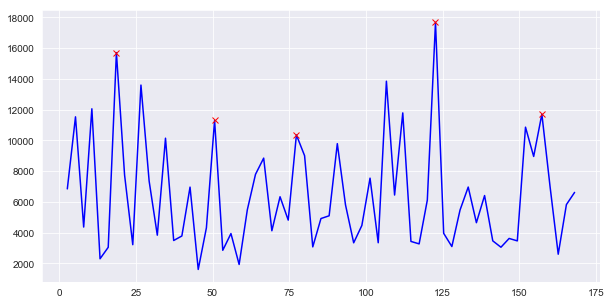

In [67]:
fig = plt.figure(figsize=(10,5))
plt.plot(x, y, 'b')
plt.plot(f_values[peaks_ind], fft_values[peaks_ind], 'x', color='r')

Definiamo una funzione per estrapolare i primi n picchi con relative frequenze e ampiezze.

In [68]:
def get_first_n_peaks(x, y, n_peaks):
    
    """
    seleziona i primi n picchi del segnale trasformato,
    restituisce le frequenze dei picchi selezionati
    e le corrispondenti ampiezze
    
    parametri:
    ----------
    x : 1D array contenente le frequenze dei picchi
    y : 1D array contentente i valori di ampiezza dei picchi
    n_peaks: numero di picchi da selezionare
    
    return:
    -------
    1D array contenente i valori delle frequenze di picco scelte
    1D array contenente i valori delle corrispondenti ampiezze
    
    """
    
    if len(x) >= n_peaks:
        
        return x[:n_peaks], y[:n_peaks]
    
    else:
        missing_n_peaks = n_peaks - len(x)
        
        peaks_x = (np.append(x[:n_peaks], np.zeros(missing_n_peaks))).astype(int)
        peaks_y = (np.append(y[:n_peaks], np.zeros(missing_n_peaks))).astype(int)
        
        return peaks_x, peaks_y

In [69]:
peaks_x, peaks_y = get_first_n_peaks(f_values[peaks_ind], fft_values[peaks_ind], n_peaks=5)

In [70]:
peaks_x, peaks_y

(array([ 18.66433362,  50.66033412,  77.32366787, 122.65133525,
        157.31366912]),
 array([15704.1243613 , 11306.20503708, 10353.01157452, 17674.8931858 ,
        11701.15198076]))

Definiamo delle funzioni che racchiudano gli step precedenti.

In [71]:
def import_data(data_path, file_name, res=True, delta_ms='3ms'):
    
    """
    importa i dati in formato .csv in un DataFrame pandas,
    aggiunge la colonna con il modulo del segnale complessivo, 
    consente di ricampionare il segnale, indicando il timing tra
    campioni consecutivi di segnale
    
    parametri :
    -----------
    data_path : percorso dei file csv dei singoli segnali
    file_name : nome del file csv del singolo segnale
    res : boolean, default True
        effettua il resampling del segnale
    delta_ms : str, default '3ms'
        definisce l'intevallo in ms per il resampling
        
    return :
    --------
    df : pandas DataFrame del segnale importato
    
    """
    
    file_path = data_path + file_name
    df = pd.read_csv(file_path, sep=',', index_col=0,
                     names=['date_time', 'x', 'y', 'z', 'i'])
    df.index = pd.to_datetime(df.index)
    df['m'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    
    if res:
        
        df = df.resample(delta_ms).asfreq().interpolate().dropna()
    
    return df

In [72]:
def preprocess_signal_FFT(df, var, start_idx, end_idx):
    
    """
    calcola la Fast Fourier Transform del segnale catturato
    per la variabile scelta riferita a una determinata finestra temporale
    """
    
    df = df.reset_index()
    df = df[start_idx:end_idx]
           
    # applica la FFT al segnale
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    f = 1/T
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(df[var])
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
      
    return f_values, fft_values

In [73]:
def plot_preprocessed_signal_FFT(x, y, color, var="", label=""):
    
    """
    plotta il segnale processato
    
    parametri:
    ----------
    x : 1D array, f_values
    y : 1D array, fft_values
    """
    
    x, y = x[1:], y[1:]
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x, y, linestyle='-', color=color)
    plt.xlabel('Frequency [Hz]', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    plt.title("FFT of the signal " + var + ", " + label, fontsize=16)
    plt.show()

In [74]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [75]:
file_name = "3_coffee-pouring-hard-20180920--15_33_50.csv"

In [76]:
df = import_data(data_path, file_name, delta_ms='3ms')

In [77]:
df.head()

x        y       z       i             m
date_time                                                             
2018-09-20 15:33:50.586 -1644.0  14448.0    72.0  2127.0  14541.410661
2018-09-20 15:33:50.589 -1552.0  18752.0 -3692.0  2110.0  19174.907353
2018-09-20 15:33:50.592   630.0  17116.0 -3040.0  2120.5  17544.216335
2018-09-20 15:33:50.595  2812.0  15480.0 -2388.0  2131.0  15913.525317
2018-09-20 15:33:50.598 -1808.0  16280.0   972.0  2138.0  16408.901487

In [78]:
f_values, fft_values = preprocess_signal_FFT(df, 'x', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

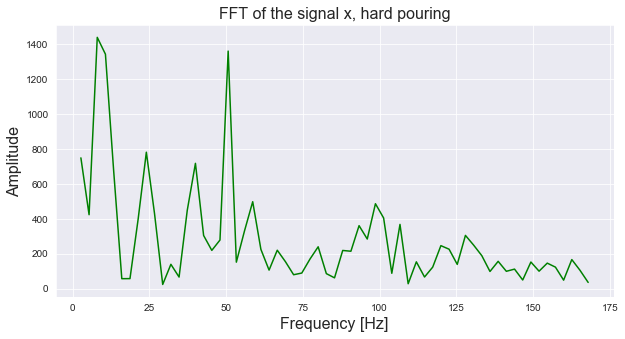

In [79]:
plot_preprocessed_signal_FFT(f_values, fft_values, var='x', color='g', label='hard pouring')

<Figure size 432x288 with 0 Axes>

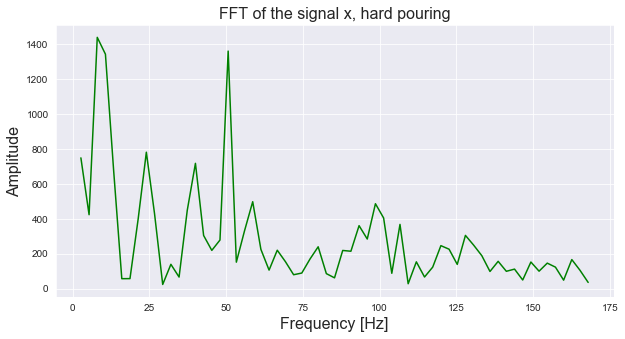

In [80]:
# più concisamente
plot_preprocessed_signal_FFT(*preprocess_signal_FFT(import_data(data_path, file_name, delta_ms='3ms'),
                                var='x', start_idx=0, end_idx=128), var='x', color='g', label='hard pouring')

Il segnale, rappresentato nello spazio delle frequenze, appare molto irregolare per via del rumore presente. Possiamo utilizzarlo tal quale, per non perdere informazione, o applicare dei filtri per renderlo più regolare con il rischio di perdere informazione importante ai fini della caratterizzazione e classificazione del segnale stesso.

----

Valutiamo se i dati di corrente contengono informazione utile a discriminare le varie modalità di funzionamento.

In [81]:
all_files

['C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\1_coffee-pouring-empty-20180920--15_30_41.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\2_coffee-pouring-normal-20180920--15_24_10.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\3_coffee-pouring-hard-20180920--15_33_50.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\4_coffee-moving-20180920--15_35_14.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\5_coffee-standby-20180920--15_17_26.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\6_ coffee-steam-20180920--15_37_37.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\7_coffee-pouring-normal-moving-20180920--15_27_56.csv']

In [82]:
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

In [83]:
file_name = "1_coffee-pouring-empty-20180920--15_30_41.csv"

In [84]:
df_norm = import_data(data_path, file_name)

In [85]:
df_norm.head()

x             y       z            i  \
date_time                                                                 
2018-09-20 15:30:41.730 -5632.000000  13304.000000  5184.0  2142.000000   
2018-09-20 15:30:41.733 -3633.333333  13857.333333  1820.0  2137.666667   
2018-09-20 15:30:41.736 -1634.666667  14410.666667 -1544.0  2133.333333   
2018-09-20 15:30:41.739   364.000000  14964.000000 -4908.0  2129.000000   
2018-09-20 15:30:41.742  5018.000000  15772.000000 -6848.0  2117.500000   

                                    m  
date_time                              
2018-09-20 15:30:41.730  15348.931429  
2018-09-20 15:30:41.733  15483.464863  
2018-09-20 15:30:41.736  15617.998298  
2018-09-20 15:30:41.739  15752.531733  
2018-09-20 15:30:41.742  18431.749370

In [86]:
f_values, fft_values = preprocess_signal_FFT(df_norm, var='i', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

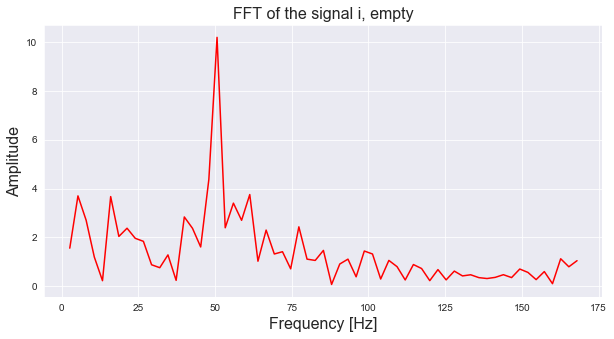

In [87]:
plot_preprocessed_signal_FFT(f_values, fft_values, var='i', color='r', label='empty')

In [88]:
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"

<Figure size 432x288 with 0 Axes>

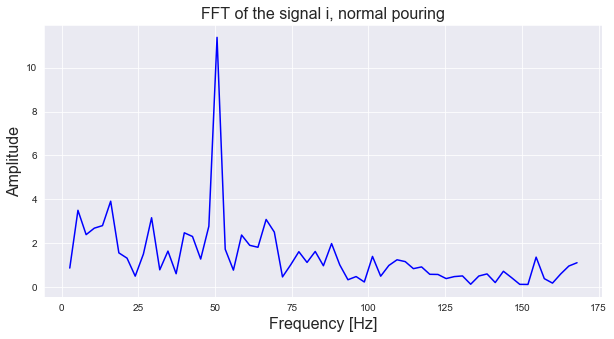

In [89]:
plot_preprocessed_signal_FFT(*preprocess_signal_FFT(import_data(data_path, file_name, delta_ms='3ms'),
                                var='i', start_idx=0, end_idx=128), var='i', color='b', label='normal pouring')

In [90]:
file_name = "3_coffee-pouring-hard-20180920--15_33_50.csv"

<Figure size 432x288 with 0 Axes>

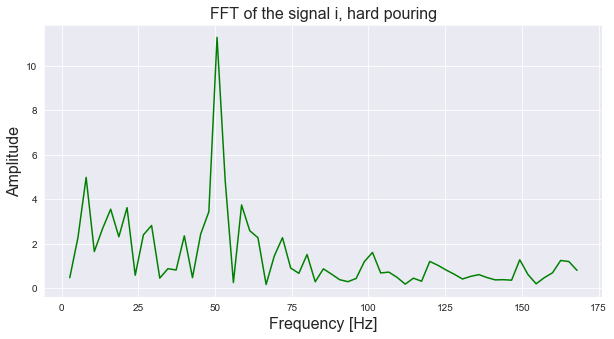

In [91]:
plot_preprocessed_signal_FFT(*preprocess_signal_FFT(import_data(data_path, file_name, delta_ms='3ms'),
                                var='i', start_idx=0, end_idx=128), var='i', color='g', label='hard pouring')

Confrontiamo le trasformate in un'unica figura.

In [92]:
f_values_E, fft_values_E = preprocess_signal_FFT(import_data(data_path,
                                  file_name = "1_coffee-pouring-empty-20180920--15_30_41.csv", delta_ms='3ms'), 
                      var='i', start_idx=0, end_idx=128)
f_values_N, fft_values_N = preprocess_signal_FFT(import_data(data_path,
                                  file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv", delta_ms='3ms'), 
                      var='i', start_idx=0, end_idx=128)
f_values_H, fft_values_H = preprocess_signal_FFT(import_data(data_path,
                                  file_name = "3_coffee-pouring-hard-20180920--15_33_50.csv", delta_ms='3ms'), 
                      var='i', start_idx=0, end_idx=128)

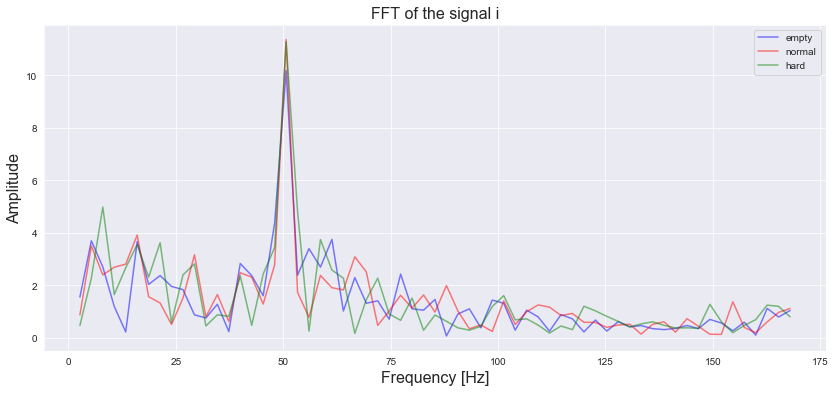

In [93]:
plt.figure(figsize=(14,6))
plt.plot(f_values_E[1:], fft_values_E[1:], linestyle='-', color="b", alpha=0.5, label='empty')
plt.plot(f_values_N[1:], fft_values_N[1:], linestyle='-', color="r", alpha=0.5, label='normal')
plt.plot(f_values_H[1:], fft_values_H[1:], linestyle='-', color="g", alpha=0.5, label='hard')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT of the signal i", fontsize=16)
plt.legend()
plt.show()

Utilizziamo plotly per una visualizzazione più interattiva.

In [94]:
import cufflinks as cf

In [95]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [96]:
init_notebook_mode(connected=True)

In [97]:
cf.go_offline()

In [98]:
len(fft_values_E)

64

In [99]:
df_e = import_data(data_path, file_name="1_coffee-pouring-empty-20180920--15_30_41.csv")

In [100]:
N, delta_time_sec, T, fs = get_signal_properties(df_e, start_time_idx=0, end_time_idx=128)

In [101]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [102]:
df_n = import_data(data_path, file_name="2_coffee-pouring-normal-20180920--15_24_10.csv")

In [103]:
N, delta_time_sec, T, fs = get_signal_properties(df_n, start_time_idx=0, end_time_idx=128)

In [104]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [105]:
df_h = import_data(data_path, file_name="3_coffee-pouring-hard-20180920--15_33_50.csv")

In [106]:
N, delta_time_sec, T, fs = get_signal_properties(df_n, start_time_idx=0, end_time_idx=128)

In [107]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [108]:
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [109]:
fft_dict = {"f_values":f_values, "fft Empty":fft_values_E, "fft Normal":fft_values_N, "fft Hard":fft_values_H}

In [110]:
df_i = pd.DataFrame(data = fft_dict)

In [111]:
df_i.head()

f_values    fft Empty   fft Normal     fft Hard
0   0.000000  4252.789062  4250.875000  4251.429688
1   2.666333     1.560022     0.881689     0.475347
2   5.332667     3.699558     3.507449     2.280724
3   7.999000     2.703775     2.401362     4.987778
4  10.665333     1.196965     2.695938     1.653822

In [112]:
df_i.drop(axis=0, index=0, inplace=True)

In [113]:
df_i.head()

f_values  fft Empty  fft Normal  fft Hard
1   2.666333   1.560022    0.881689  0.475347
2   5.332667   3.699558    3.507449  2.280724
3   7.999000   2.703775    2.401362  4.987778
4  10.665333   1.196965    2.695938  1.653822
5  13.331667   0.228697    2.810739  2.676008

In [114]:
df_i.set_index('f_values', inplace=True)

In [115]:
df_i.iplot()

Visualizzando le FFT dei dati di corrente per diverse modalità operative, appare evidente che le classi sono pressocché indistinguibili. Per cui concentreremo la nostra attenzione sui dati catturati dall'accelerometro.

### 2.1.1. Signal filtering

#### ======= You can skip the next cells if you don't want to remove the noise from the data =======

Proviamo ad applicare un filtro passa-basso per rendere più smooth il segnale.

In [116]:
# crea un filtro di Butterworth di ordine 1 e cutoff a 0.2 Hz
Nf  = 1    # Filter order
Wn = 0.2 # Cutoff frequency
B, A = butter(Nf, Wn, output='ba')

In [117]:
# applica il filtro
df_res_filt_x = filtfilt(B, A, df_res['x'])

In [118]:
df_res['x_filt'] = df_res_filt_x

In [119]:
df_res.head()

date_time            x             y       z            i  \
0 2018-09-20 15:24:10.452 -7464.000000  16632.000000  2060.0  2111.000000   
1 2018-09-20 15:24:10.455 -4024.000000  17066.000000  1708.0  2117.500000   
2 2018-09-20 15:24:10.458  -584.000000  17500.000000  1356.0  2124.000000   
3 2018-09-20 15:24:10.461  -205.333333  15913.333333   284.0  2130.666667   
4 2018-09-20 15:24:10.464   173.333333  14326.666667  -788.0  2137.333333   

        x_filt  
0 -7462.909731  
1 -4886.601198  
2 -2717.557707  
3 -1194.502136  
4  -138.468722

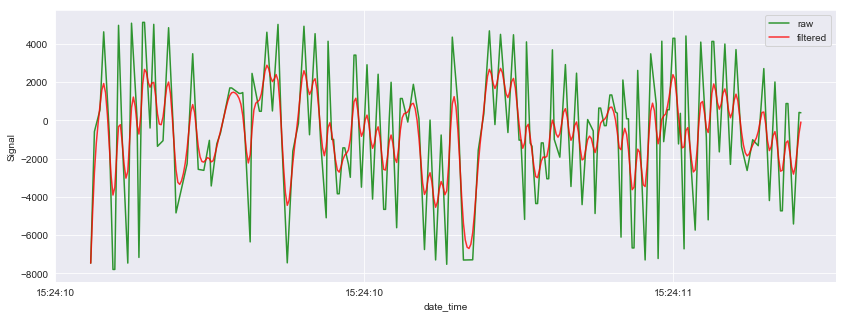

In [120]:
plt.figure(figsize=(14,5))
sns.lineplot(x='date_time', y='x', data=df_res[0:384], color='g', alpha=0.8, label='raw')
sns.lineplot(x='date_time', y='x_filt', data=df_res[0:384], color='r', alpha=0.8, label='filtered')
plt.ylabel('Signal')
plt.legend()

In [121]:
f_values, fft_values = preprocess_signal_FFT(df_res, 'x', start_idx=0, end_idx=128)

In [122]:
f_values, fft_values_filt = preprocess_signal_FFT(df_res, 'x_filt', start_idx=0, end_idx=128)

In [123]:
#plot_preprocessed_signal_FFT(f_values, fft_values, var='x', color='g', label='normal pouring')
#plot_preprocessed_signal_FFT(f_values, fft_values_filt, var='x_filt', color='r', label='normal pouring')

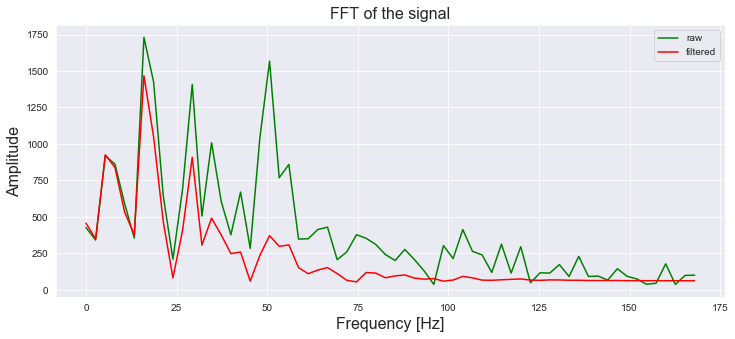

In [124]:
plt.figure(figsize=(12,5))
plt.plot(f_values, fft_values, linestyle='-', color='g', label='raw')
plt.plot(f_values, fft_values_filt, linestyle='-', color='r', label='filtered')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT of the signal", fontsize=16)
plt.legend()
plt.show()

In [125]:
def filter_signal(df, Nf, Wn, var_to_filter):
    
    """
    crea un filtro di Butterworth di ordine Nf e cutoff Wn [Hz]
    
    parametri:
    ----------
    df : pandas DataFrame contenente il segnale
    Nf  : ordine del filtro
    Wn : frequenza di cutoff
    var_to_filter : variabile a cui applicare il filtro
    
    return:
    -------
    df : pandas DataFrame con segnale filtrato
    
    """
    
    B, A = butter(Nf, Wn, output='ba')
    df[var_to_filter + '_filtered'] = filtfilt(B, A, df[var_to_filter])
    
    return df

In [126]:
df = import_data(data_path, file_name)

In [127]:
df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')

In [128]:
df.head()

x        y       z       i             m  \
date_time                                                                
2018-09-20 15:33:50.586 -1644.0  14448.0    72.0  2127.0  14541.410661   
2018-09-20 15:33:50.589 -1552.0  18752.0 -3692.0  2110.0  19174.907353   
2018-09-20 15:33:50.592   630.0  17116.0 -3040.0  2120.5  17544.216335   
2018-09-20 15:33:50.595  2812.0  15480.0 -2388.0  2131.0  15913.525317   
2018-09-20 15:33:50.598 -1808.0  16280.0   972.0  2138.0  16408.901487   

                          x_filtered  
date_time                             
2018-09-20 15:33:50.586 -1635.146587  
2018-09-20 15:33:50.589  -986.352549  
2018-09-20 15:33:50.592  -317.187048  
2018-09-20 15:33:50.595   -95.222609  
2018-09-20 15:33:50.598  -442.995301

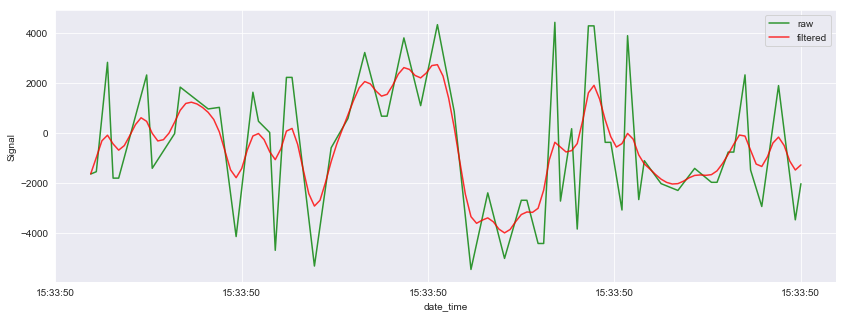

In [129]:
plt.figure(figsize=(14,5))
sns.lineplot(x='date_time', y='x', data=df.reset_index()[0:128], color='g', alpha=0.8, label='raw')
sns.lineplot(x='date_time', y='x_filtered', data=df.reset_index()[0:128], color='r', alpha=0.8, label='filtered')
plt.ylabel('Signal')
plt.legend()

#### ==============

Decidiamo una funzione di plot generale, valida per ogni tipo di processing.

In [130]:
def plot_preprocessed_signal(x, y, process, color, var="", label=""):
    
    """
    plotta il segnale processato
    
    parametri:
    ----------
    x : 1D array, x_values
    y : 1D array, y_values
    
    parametri per la formattazione del plot:
    ----------------------------------------
    process : processo di trasformazione
    color : colore della funzione visualizzata
    label : tipo di modalità di funzionamento
    
    """
    
    xlabels = {0:'Frequency [Hz]', 1:'Frequency [Hz]', 2:'Time delay [s]'}
    ylabels = {0:'Amplitude', 1:'PSD [V**2 / Hz]', 2:'Autocorrelation amplitude'}
    titles = {0:'FFT', 1:'PSD', 2:'Autocorrelation'}
    processing_types = {'FFT':0, 'PSD':1, 'aCorr':2}
    
    x, y = x[1:], y[1:]
    
    i = processing_types[process]
    xlabel = xlabels[i]
    ylabel = ylabels[i]
    title = titles[i]
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))        
    ax.plot(x, y, linestyle='-', color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title+" of the signal " + var + ", " + label, fontsize=16)
    plt.show()

Calcoliamo la FFT per **tutti i file** e plottiamola

In [131]:
files_list = os.listdir(data_path)

In [132]:
files_list

['1_coffee-pouring-empty-20180920--15_30_41.csv',
 '2_coffee-pouring-normal-20180920--15_24_10.csv',
 '3_coffee-pouring-hard-20180920--15_33_50.csv',
 '4_coffee-moving-20180920--15_35_14.csv',
 '5_coffee-standby-20180920--15_17_26.csv',
 '6_ coffee-steam-20180920--15_37_37.csv',
 '7_coffee-pouring-normal-moving-20180920--15_27_56.csv']

In [133]:
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

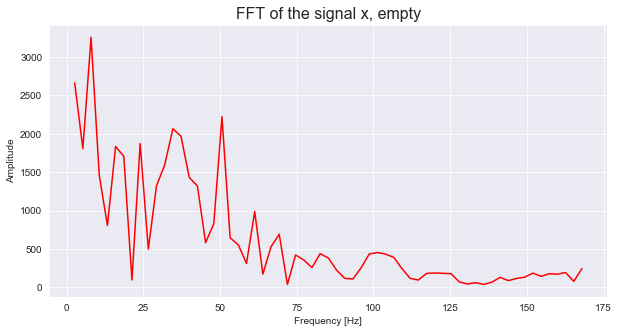

<Figure size 432x288 with 0 Axes>

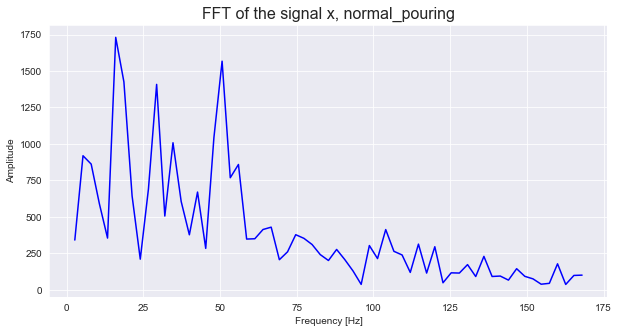

<Figure size 432x288 with 0 Axes>

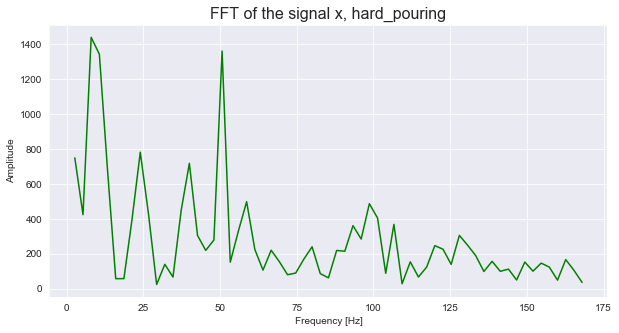

<Figure size 432x288 with 0 Axes>

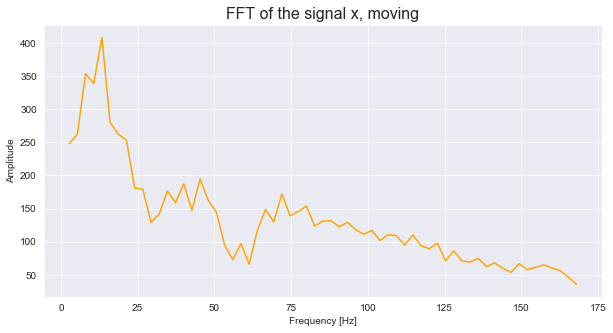

<Figure size 432x288 with 0 Axes>

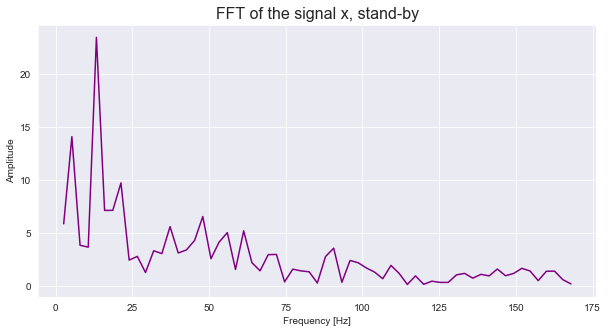

<Figure size 432x288 with 0 Axes>

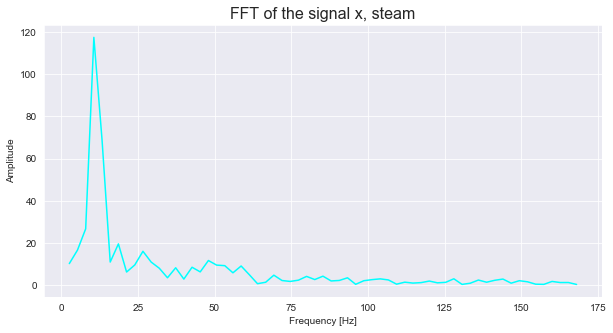

<Figure size 432x288 with 0 Axes>

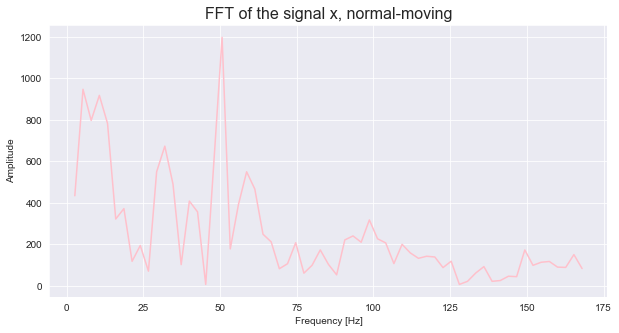

In [134]:
files_list.sort()

for f in files_list:
    
    if f[0].isdigit():
        
        file_name = f
        c = file_name[0]
        df = import_data(data_path, file_name, delta_ms='3ms')
        # decommmenta le due righe successiva e commenta la terza per applicare il filtro
        #df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')
        #x, y = preprocess_signal_FFT(df, var='x_filtered', start_idx=0, end_idx=128)
        x, y = preprocess_signal_FFT(df, var='x', start_idx=0, end_idx=128)
        plot_preprocessed_signal(x, y, var='x', process='FFT', color=colors[c], label=labels[c])

### 2.2. Pre-processing PSD

Un altro modo per analizzare lo spettro delle frequenze consiste nel calcolare la densità spettrale di potenza PSD. Calcoliamo la PSD per il **singolo file.**

In [135]:
def preprocess_signal_PSD(df, var, start_idx, end_idx):
    
    """
    calcola la Power Spectral Density PSD del segnale catturato
    per la variabile scelta riferita a una determinata finestra temporale
    """

    df = df.reset_index()
    df = df[start_idx:end_idx]
    
    # applica la PSD al segnale
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    f = 1/T
    samples = end_idx-start_idx
    f_values, psd_values = welch(df[var], fs=f, nperseg=samples)
       
    return f_values, psd_values

In [136]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [137]:
file_name = '3_coffee-pouring-hard-20180920--15_33_50.csv'

In [138]:
df = import_data(data_path, file_name)

In [139]:
df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')

In [140]:
f_values, psd_values = preprocess_signal_PSD(df, var='x_filtered', start_idx=0, end_idx=128)

In [141]:
f_values.size, psd_values.size

(65, 65)

<Figure size 432x288 with 0 Axes>

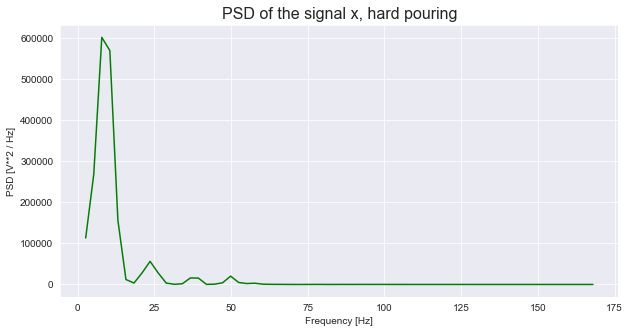

In [142]:
plot_preprocessed_signal(f_values, psd_values, process='PSD', var='x', color='g', label='hard pouring')

In [143]:
psd_threshold = 0.01*(np.max(psd_values) - np.min(psd_values))

In [144]:
# la distanza in questo caso è definita come numero di sample tra picchi
peaks_ind, _ = find_peaks(psd_values, threshold=psd_threshold, distance=5) 

In [145]:
peaks_ind

array([ 3,  9, 19], dtype=int64)

In [146]:
psd_peaks = psd_values[peaks_ind]

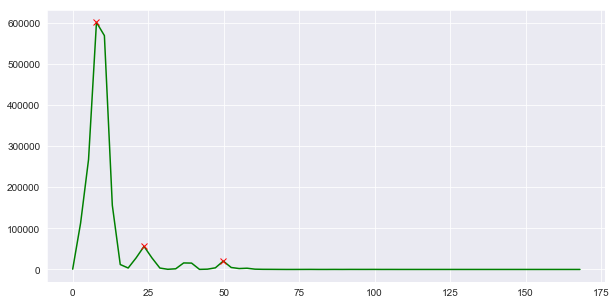

In [147]:
fig = plt.figure(figsize=(10,5))
plt.plot(f_values, psd_values, 'g')
plt.plot(f_values[peaks_ind], psd_values[peaks_ind], 'x', color='r')

Calcoliamo la PSD per **tutti i file** e plottiamola.

In [148]:
files_list = os.listdir(data_path)
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

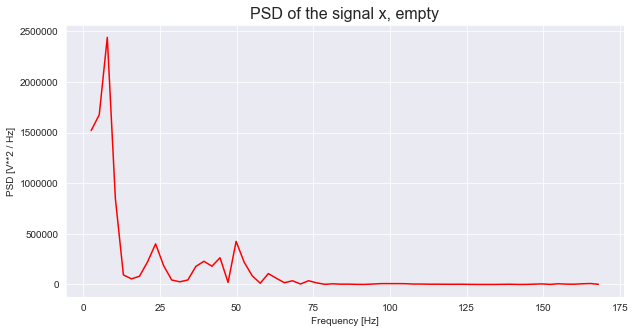

<Figure size 432x288 with 0 Axes>

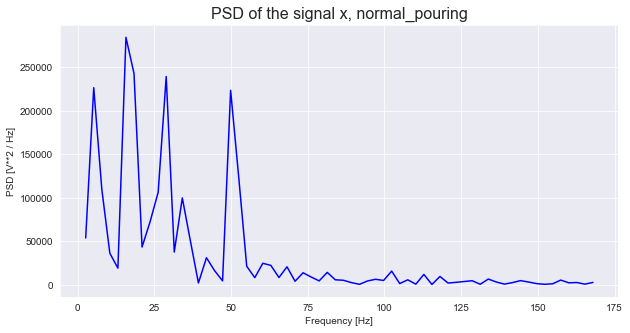

<Figure size 432x288 with 0 Axes>

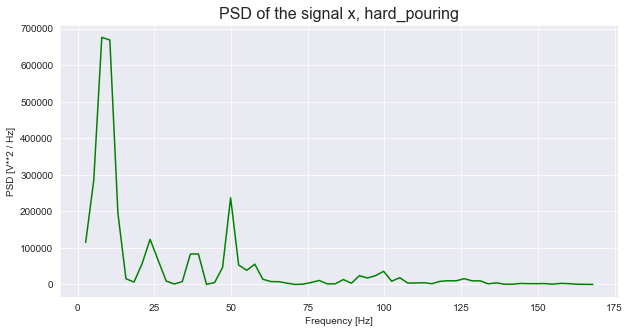

<Figure size 432x288 with 0 Axes>

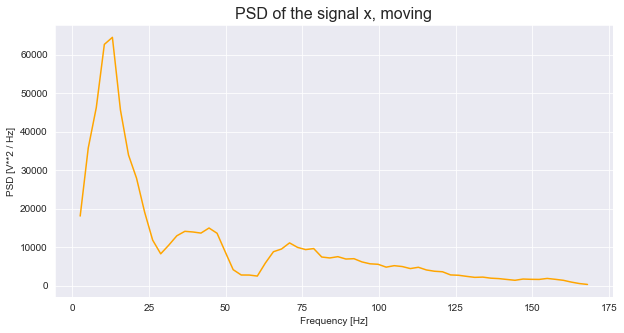

<Figure size 432x288 with 0 Axes>

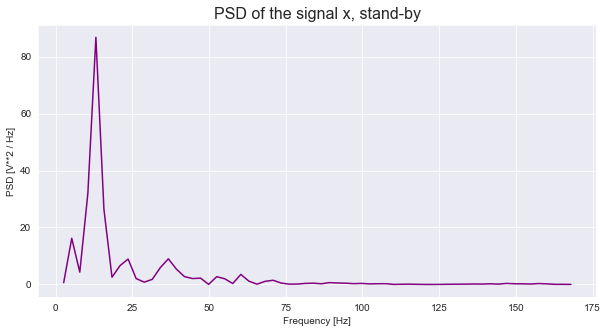

<Figure size 432x288 with 0 Axes>

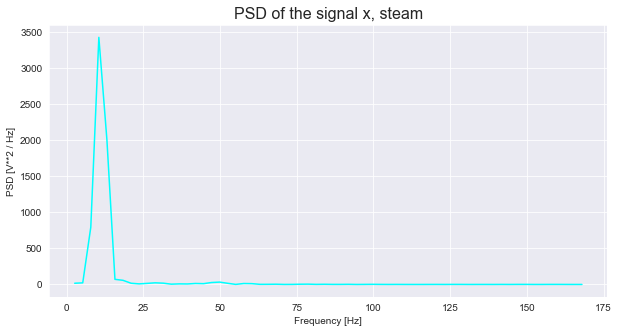

<Figure size 432x288 with 0 Axes>

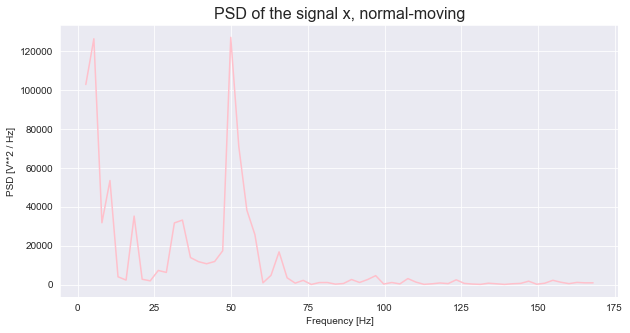

In [149]:
files_list.sort()

for f in files_list:
    
    if f[0].isdigit():
        
        file_name = f
        c = file_name[0]
        df = import_data(data_path, file_name, delta_ms='3ms')
        # decommmenta le due righe successiva e commenta la terza per applicare il filtro        
        #df = filter_signal(df, Nf=1, Wn=0.3, var_to_filter='x')
        #x, y = preprocess_signal_PSD(df, var='x_filtered', start_idx=0, end_idx=128)
        x, y = preprocess_signal_PSD(df, var='x', start_idx=0, end_idx=128)
        plot_preprocessed_signal(x, y, var='x', process='PSD', color=colors[c], label=labels[c])

### 2.3. Pre-processing autocorrelation index

Calcola quanto il segnale è correlato con una versione "ritardata" del segnale stesso. Calcoliamo l'autocorrelation index per il **singolo file.**

In [150]:
def preprocess_signal_autocorr(df, var, start_idx, end_idx):
    
    """
    calcola l'indice di autocorrelazione del segnale catturato
    per la variabile scelta riferita a una determinata finestra temporale
    """
    
    df = df.reset_index()
    df = df[start_idx:end_idx]
    
    delta_time_sec = (df['date_time'][end_idx - 1] - df['date_time'][start_idx]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    f = 1/T
    
    # calcola l'autocorrelation index
    result = np.correlate(df[var], df[var], mode='full')
    autocorr_values = result[result.size//2:]
    t_values = np.array([T*jj for jj in range(0, N)])
    
    return  t_values, autocorr_values

In [151]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

In [152]:
df = import_data(data_path, file_name)

In [153]:
df = filter_signal(df, Nf=1, Wn=0.3, var_to_filter='x')

In [154]:
t_values, autocorr_values = preprocess_signal_autocorr(df, var='x_filtered', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

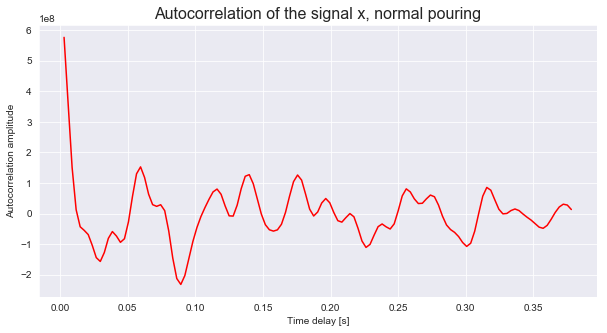

In [155]:
plot_preprocessed_signal(t_values, autocorr_values, process='aCorr', var='x', color='r', label='normal pouring')

In [156]:
peaks_ind, _ = find_peaks(autocorr_values, threshold=None, distance=10)

In [157]:
peaks_ind

array([ 20,  47,  59,  72,  86, 106, 125], dtype=int64)

In [158]:
t_values[peaks_ind]

array([0.05953125, 0.13989844, 0.17561719, 0.2143125 , 0.25598437,
       0.31551563, 0.37207031])

In [159]:
autocorr_peaks = autocorr_values[peaks_ind]
autocorr_peaks

array([ 1.52455740e+08,  1.27049969e+08,  1.25881985e+08, -1.89856416e+05,
        8.05953017e+07,  8.52495717e+07,  3.04617134e+07])

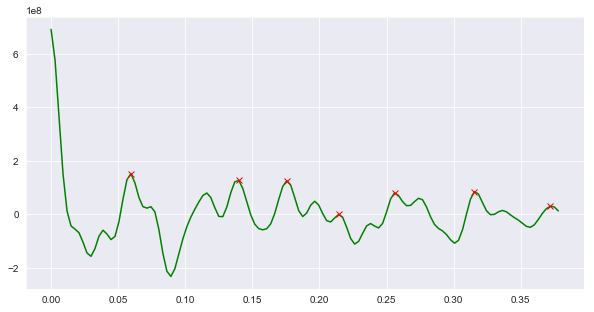

In [160]:
fig = plt.figure(figsize=(10,5))
plt.plot(t_values, autocorr_values, 'g')
plt.plot(t_values[peaks_ind], autocorr_values[peaks_ind], 'x', color='r')

In [161]:
# seleziona il numero di picchi desiderato
peak_x, peak_y = get_first_n_peaks(t_values[peaks_ind], autocorr_values[peaks_ind], n_peaks=5)

In [162]:
peak_x, peak_y

(array([0.05953125, 0.13989844, 0.17561719, 0.2143125 , 0.25598437]),
 array([ 1.52455740e+08,  1.27049969e+08,  1.25881985e+08, -1.89856416e+05,
         8.05953017e+07]))

Calcoliamo l'autocorrelation index per **tutti i file.**

In [163]:
files_list = os.listdir(data_path)

In [164]:
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

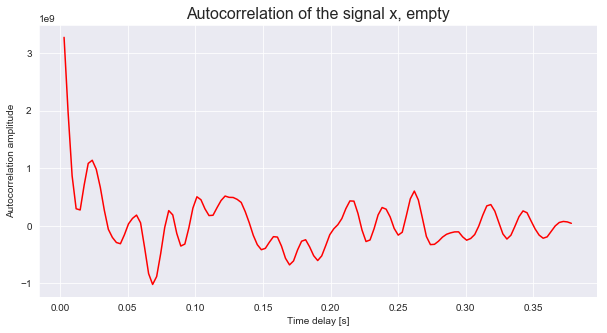

<Figure size 432x288 with 0 Axes>

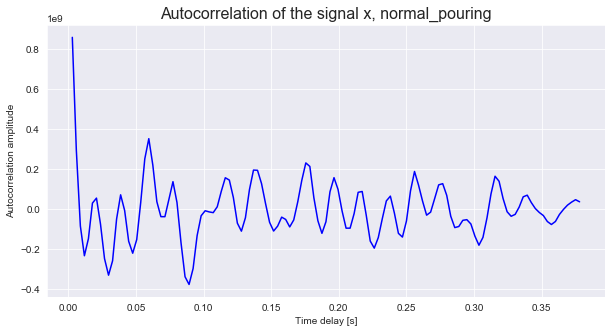

<Figure size 432x288 with 0 Axes>

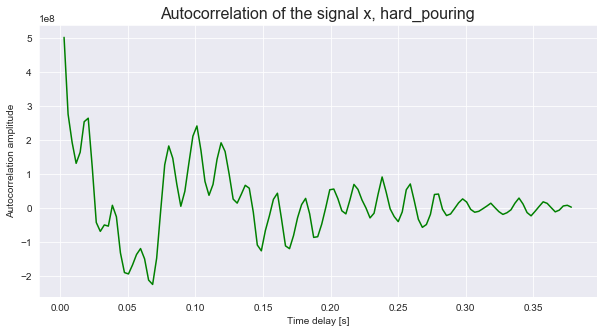

<Figure size 432x288 with 0 Axes>

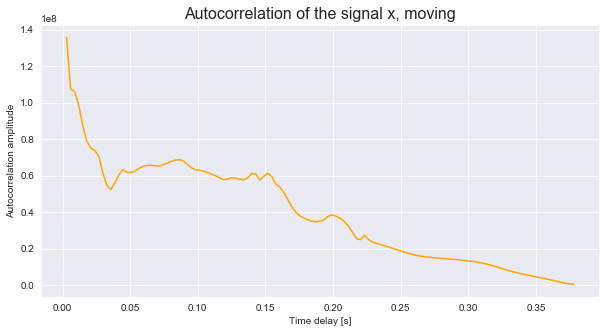

<Figure size 432x288 with 0 Axes>

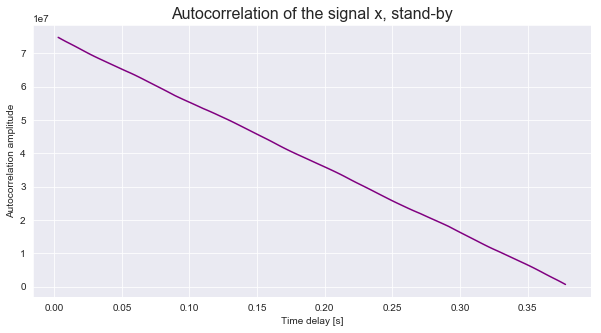

<Figure size 432x288 with 0 Axes>

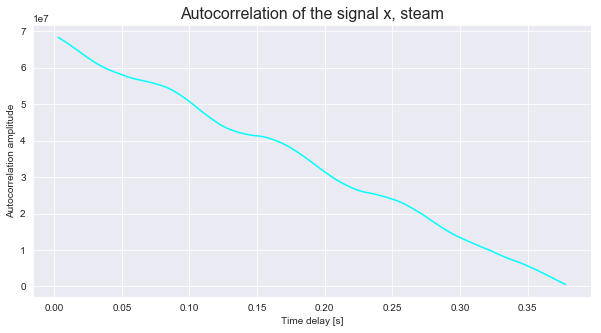

<Figure size 432x288 with 0 Axes>

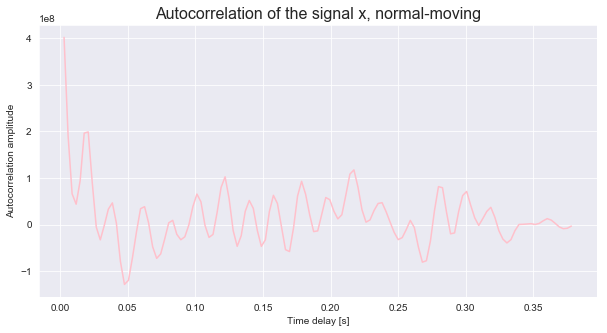

In [165]:
files_list.sort()

for f in files_list:
    
    if f[0].isdigit():
        
        file_name = f
        c = file_name[0]
        df = import_data(data_path, file_name, delta_ms='3ms')
        # decommmenta le due righe successiva e commenta la terza per applicare il filtro 
        #df = filter_signal(df, Nf=1, Wn=0.3, var_to_filter='x')
        #x, y = preprocess_signal_autocorr(df, var='x_filtered', start_idx=0, end_idx=128)
        x, y = preprocess_signal_autocorr(df, var='x', start_idx=0, end_idx=128)
        plot_preprocessed_signal(x, y, var='x', process='aCorr', color=colors[c], label=labels[c])

Condensiamo il preprocessing del segnale in un'unica funzione

In [166]:
def preprocess_signal(df, var, process, start_idx, end_idx):
    
    """
    effettua il preprocessing del segnale scelto, in base al tipo di processo
    passato come parametro, riferito alla finestra temporale selezionata

    parametri:
    ----------
    
    df : pandas DataFrame, serie storica di una o più variabili
    var : str, variabile da processare
    process : str, tipo di trasformazione
            {'FFT': Fast Fourier Transform,
             'PSD': Power Spectral Density,
             'aCorr': Autocorrelation Index}
    start_idx : int, indice dell'istante iniziale
    end_idx : int, indice dell'istante finale
    
    return:
    -------
    x : x del segnale processato (frequenza o intervallo temporale)
    y : y del del segnale processato (ampiezza o indice di autocorrelazione)
    
    """
    
    df = df.reset_index()
    df = df[start_idx:end_idx]
    
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    f = 1/T
    
    if process == 'FFT':        
        # applica la FFT al segnale
        f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
        fft_values_ = fft(df[var])
        fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
      
        return f_values, fft_values
    
    elif process == 'PSD':
        # applica la PSD al segnale
        samples = end_idx-start_idx
        f_values, psd_values = welch(df[var], fs=f, nperseg=samples)

        return f_values, psd_values
    
    elif process == 'aCorr':
        # calcola l'autocorrelation index
        result = np.correlate(df[var], df[var], mode='full')
        autocorr_values = result[result.size//2:]
        t_values = np.array([T*jj for jj in range(0, N)])
    
        return  t_values, autocorr_values
    
    else:
        print("Process is not valid!\n")
        print("Processes available are: 'FFT', 'PSD', 'aCorr'. Enter a valid process.")
        return False, False

In [167]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

In [168]:
df = import_data(data_path, file_name, res= True, delta_ms='3ms')

In [169]:
df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')

In [170]:
x, y = preprocess_signal(df, var='x_filtered', process='FFT',start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

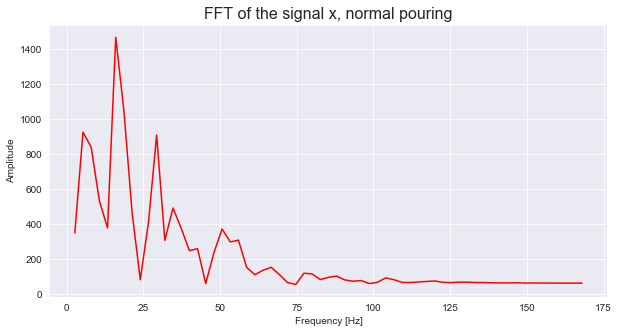

In [171]:
plot_preprocessed_signal(x, y, process='FFT', color='r', var='x', label='normal pouring')

In [172]:
x, y = preprocess_signal(df, var='x_filtered', process='PSD',start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

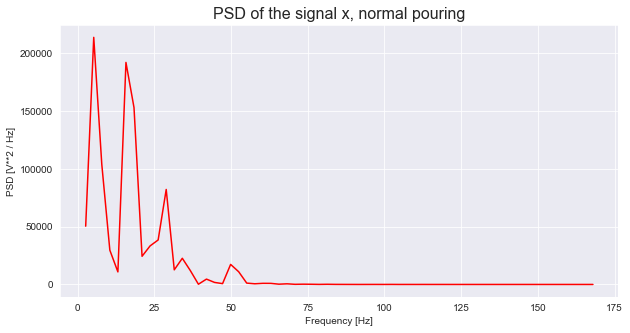

In [173]:
plot_preprocessed_signal(x, y, process='PSD', color='r', var='x', label='normal pouring')

In [174]:
x, y = preprocess_signal(df, var='x_filtered', process='aCorr', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

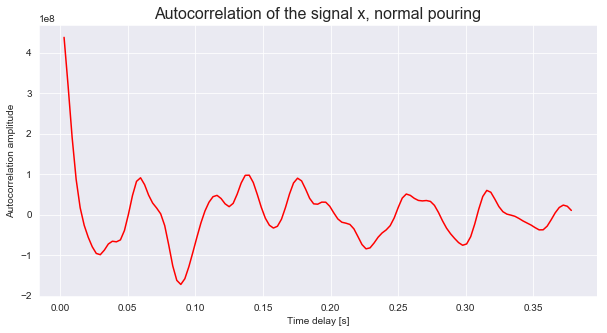

In [175]:
plot_preprocessed_signal(x, y, process='aCorr', color='r', var='x', label='normal pouring')

In [176]:
x, y = preprocess_signal(df, var='x_filtered', process='FT',start_idx=0, end_idx=128)

Process is not valid!

Processes available are: 'FFT', 'PSD', 'aCorr'. Enter a valid process.


## 3. Data preparation for modelling

I seguenti step sono finalizzati a preaparare i dati per la parte di modelling a partire dai singoli file csv contenenti il segnale campionato per le differenti modalità di funzionamento che si intende classificare.

In sintesi si procede a:
- Bilanciare le classi per ottenere segnali di pari dimensione per ogni classe
- Importare i singoli segnali (con possibilità di ricampionamento) e annotarli (labelling)
- Suddividere ciascun segnale in due gruppi di buffer consecutivi, uno per il training e l'altro per il test, per ciascuna classe e per ciascuna variabile da analizzare
- Riorganizzare ciascun segnale in modo da ottenere una struttura in cui ad ogni record corrisponde un buffer costituito da un certo numero di campioni, con la possibilità di sovrapposizione tra buffer consecutivi
- Aggregare i dati in un'unica struttura contenente tutte le classi, per ciascuna variabile
- Estrarre delle feature da ogni buffer, basate sulle trasformazioni precedentemente definite
- Creare due dataset (uno per il training e uno per il test) contenenti tutti i segnali con le relative feature estratte da ogni buffer

In [177]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

In [178]:
files_list = os.listdir(data_path)

In [179]:
files_list

['1_coffee-pouring-empty-20180920--15_30_41.csv',
 '2_coffee-pouring-normal-20180920--15_24_10.csv',
 '3_coffee-pouring-hard-20180920--15_33_50.csv',
 '4_coffee-moving-20180920--15_35_14.csv',
 '5_coffee-standby-20180920--15_17_26.csv',
 '6_ coffee-steam-20180920--15_37_37.csv',
 '7_coffee-pouring-normal-moving-20180920--15_27_56.csv']

In [180]:
files_list.sort()

nsamples_lst = []

for f in files_list:
    
    if f[0].isdigit():
        
        file_name = f
        c = file_name[0]
        df = pd.read_csv(data_path + f, delimiter=',', header=None)
        
        nsamples_lst.append(df.shape[0])
        
        print("Il file {0} contiene {1} sample".format(f, df.shape[0]))

Il file 1_coffee-pouring-empty-20180920--15_30_41.csv contiene 10230 sample
Il file 2_coffee-pouring-normal-20180920--15_24_10.csv contiene 25575 sample
Il file 3_coffee-pouring-hard-20180920--15_33_50.csv contiene 10230 sample
Il file 4_coffee-moving-20180920--15_35_14.csv contiene 10230 sample
Il file 5_coffee-standby-20180920--15_17_26.csv contiene 51150 sample
Il file 6_ coffee-steam-20180920--15_37_37.csv contiene 15345 sample
Il file 7_coffee-pouring-normal-moving-20180920--15_27_56.csv contiene 25575 sample


Per avere lo stesso numero di sample per ogni classe, prendiamo la classe meno numerosa e selezioniamo lo stesso numero di campioni per tutte le restanti classi. Selezioniamo poi una parte di questi esempi per il training e l'altro per il testing, scegliendo uno split ratio.

In [181]:
less_num_class = min(nsamples_lst)

print("Il file {0} con {1} sample rappresenta la classe meno numerosa".format(
    files_list[nsamples_lst.index(less_num_class)], less_num_class))

Il file 1_coffee-pouring-empty-20180920--15_30_41.csv con 10230 sample rappresenta la classe meno numerosa


Questa funzione genara un dataframe con tutte le variabili.

In [182]:
def import_data(data_path, file_name, res=True, delta_ms='3ms'):
    
    """
    importa i dati in formato .csv in un DataFrame pandas,
    aggiunge la colonna con il modulo del segnale complessivo, 
    consente di ricampionare il segnale, indicando il timing tra
    campioni consecutivi di segnale
    
    parametri :
    -----------
    data_path : percorso dei file csv dei singoli segnali
    file_name : nome del file csv del singolo segnale
    res : boolean, default True
        effettua il resampling del segnale
    delta_ms : str, default '3ms'
        definisce l'intevallo in ms per il resampling
        
    return :
    --------
    df : pandas DataFrame del segnale importato
    
    """
    
    file_path = data_path + file_name
    df = pd.read_csv(file_path, sep=',', index_col=0,
                     names=['date_time', 'x', 'y', 'z', 'i'])
    df.index = pd.to_datetime(df.index)
    df['m'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    
    if res:
        
        df = df.resample(delta_ms).asfreq().interpolate().dropna()
    
    return df

In [183]:
def prepare_data(file_name, end_index, split_ratio):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi e il formato
    delle colonne, aggiunge la label in base al nome del file,  lo divide
    in due df separati secondo lo split_ratio e li salva in due file .csv,
    uno per il training e l'altro per il test in due directory differenti
    
    prametri :
    ----------
    file_name : str, nome del file csv da importare
    end_index : int, indice dell'ultima riga (campione)
                del segnale originario
    split_ratio : float in [0,1], ratio di separazione
                del segnale in train e test
                (ex.: split_ratio=0.7 --> 70% del segnale in train set
                                          30% del segnale in test set)    
    
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal pouring', '3':'hard pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    split_index = int(end_index * split_ratio)
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df = df[0:end_index]
    
    df_train = df[0:split_index]
    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] + ".csv", sep=",",
                    index=False, encoding='utf-8')
    df_test = df[split_index:]
    df_test.to_csv(data_path+"INPUT_TEST\\" + label + "_test_" + labels[label] + ".csv", sep=",",
                   index=False, encoding='utf-8')

In [184]:
def prepare_res_data(file_name, split_ratio, res=True, delta_ms='3ms'):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi e il formato
    delle colonne, aggiunge la label in base al nome del file,  lo divide
    in due df separati secondo lo split_ratio e li salva in due file .csv,
    uno per il training e l'altro per il test in due directory differenti.
    Consente di ricampionare il segnale, indicando il timing tra campioni
    consecutivi di segnale
    
    prametri :
    ----------
    file_name : str, nome del file csv da importare
    split_ratio : float in [0,1], ratio di separazione
                del segnale in train e test
                (ex.: split_ratio=0.7 --> 70% del segnale in train set
                                          30% del segnale in test set)
    res : boolean, default True
          effettua il resampling del segnale
    delta_ms : str, default '3ms'
               definisce l'intevallo in ms per il resampling
    
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal pouring', '3':'hard pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', index_col=0,
                     names=['date_time', 'x', 'y', 'z', 'i'])
    df.index = pd.to_datetime(df.index)
    
    if res:
        
        df = df.resample(delta_ms).asfreq().interpolate().dropna()
    
    end_index = df.shape[0] - 1
    split_index = int(end_index * split_ratio)
    
    df = df.reset_index()
    df = df[0:end_index]

    df_train = df[0:split_index]
    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] + ".csv", sep=",",
                    index=False, float_format='%.3f', encoding='utf-8')
    df_test = df[split_index:]
    df_test.to_csv(data_path + "INPUT_TEST\\" + label + "_test_" + labels[label] + ".csv", sep=",",
                   index=False, float_format='%.3f', encoding='utf-8')

In [185]:
#data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [186]:
# test con un singolo file
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
prepare_res_data(file_name, split_ratio=0.7)

In [187]:
# per tutti i file della cartella
files_list.sort()

for f in files_list:
    
    if f[0].isdigit():
    
        prepare_res_data(f, split_ratio=0.7)

Questa funzione genera un diverso dataset per ciascuna variabile.

In [188]:
def prepare_data_split_variables(file_name, end_index, split_ratio, var_to_store):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi e il formato
    delle colonne, aggiunge la label in base al nome del file, lo divide
    in due df separati secondo lo split_ratio, selezionando una variabile,
    e li salva in due file .csv, uno per il training e l'altro per il test
    in due directory differenti
    
    prametri :
    ----------
    file_name : str, nome del file csv da importare
    end_index : int, indice dell'ultima riga (campione)
                del segnale originario
    split_ratio : float in [0,1], ratio di separazione
                del segnale in train e test
                (ex.: split_ratio=0.7 --> 70% del segnale in train set
                                          30% del segnale in test set)
    var_to_store : str, variabile da processare e salvare nel file csv
    
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}
    split_index = int(end_index * split_ratio)
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['label'] = label
        
    df = df[0:end_index]

    df_train = df[0:split_index]
    #df_train_label = df_train['label'].values
    df_train = df_train.drop('label', axis=1)

    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], float_format='%.3f', encoding='utf-8')
    df_test = df[split_index:]
    #df_test_label = df_test['label'].values
    df_test = df_test.drop('label', axis=1)


    df_test.to_csv(data_path+"INPUT_TEST\\" + label + "_test_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], float_format='%.3f', encoding='utf-8')

In [189]:
def prepare_res_data_split_variables(file_name, split_ratio, var_to_store, res=True, delta_ms='3ms'):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi e il formato
    delle colonne, aggiunge la label in base al nome del file, lo divide
    in due df separati secondo lo split_ratio, selezionando una variabile,
    e li salva in due file .csv, uno per il training e l'altro per il test
    in due directory differenti. Consente di ricampionare il segnale,
    indicando il timing tra campioni consecutivi di segnale
    
    prametri :
    ----------
    file_name : str, nome del file csv da importare
    split_ratio : float in [0,1], ratio di separazione
                del segnale in train e test
                (ex.: split_ratio=0.7 --> 70% del segnale in train set
                                          30% del segnale in test set)
    var_to_store : str, variabile da processare e salvare nel file csv
    res : boolean, default True
          effettua il resampling del segnale
    delta_ms : str, default '3ms'
               definisce l'intevallo in ms per il resampling
    
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', index_col=0,
                     names=['date_time', 'x', 'y', 'z', 'i'])
    df.index = pd.to_datetime(df.index)
    
    if res:
        
        df = df.resample(delta_ms).asfreq().interpolate().dropna()
    
    df['label'] = label
    end_index = df.shape[0] - 1
    split_index = int(end_index * split_ratio)        
    df = df.reset_index()    
    df = df[0:end_index]
    #print(df.shape)

    df_train = df[0:split_index]
    #df_train_label = df_train['label'].values
    df_train = df_train.drop('label', axis=1)
    #print(df_train.shape)

    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], float_format='%.3f',
                    encoding='utf-8')
    
    df_test = df[split_index:]
    #df_test_label = df_test['label'].values
    df_test = df_test.drop('label', axis=1)
    #print(df_test.shape)

    df_test.to_csv(data_path + "INPUT_TEST\\" + label + "_test_" + labels[label] + 
                   "_" + var_to_store + "_.csv", sep=",", index=False,
                   columns=[cols[0], var_to_store], float_format='%.3f',
                   encoding='utf-8')

In [190]:
# test con un singolo file
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
prepare_res_data_split_variables(file_name, split_ratio=0.7, var_to_store='x', res=True)

In [191]:
# per tutti i file della cartella
cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}
files_list.sort()

for f in files_list:
    
    if f[0].isdigit():
            
        for i in range(1,4):

            prepare_res_data_split_variables(f, split_ratio=0.7, var_to_store=cols[i])

### 3.1. Data reshape

Riorganizziamo i dati secondo una struttura in cui ad ogni riga corrisponde un buffer del segnale campionato e per colonne i valori assunti da ciascun campione per ogni variabile. Tutti i segnali corrispondenti alle modalità di funzionamento saranno concatenati. Otterremo infine tre file csv, uno per ogni variabile.

In [192]:
def get_input_signals(file_name, nsamples):
    
    """
    prende il segnale campionato e lo divide in un certo numero
    di parti (buffer) sulla base del numero di campioni selezionati [nsamples],
    generando un df pandas di dimensioni (num buffer * num campioni)
    che contiene i valori assunti dalla variabile misurata
    
    parametri :
    -----------
    file_name : str, nome del file csv contenente il segnale campionato
    nsamples : int, numero di campioni per buffer
    
    return :
    --------
    input_signals: pandas DatFrame del segnale ottenuto
    
    """
    
    data = pd.read_csv(file_name, sep=',', header=0)
    data.drop('date_time', axis=1, inplace=True)
    
    # riduce la lunghezza del df iniziale in modo tale che sia divisibile
    # in un numero intero di parti, dato il numero di sample scelto
    lngth = len(data) // nsamples * nsamples
    data = data[0:lngth]
    
    data.reset_index(drop=True, inplace=True)
    split_data = np.array_split(data, len(data)//(nsamples))
    
    input_signals = pd.DataFrame()

    for i in range(len(split_data)):

        data_reshaped = np.reshape(split_data[i].values, (1, -1))
        input_signals = input_signals.append(data_reshaped.tolist(), ignore_index=True)
    
    return input_signals

In [193]:
def get_input_signals_with_overlap(file_name, nsamples):
    
    """
    prende il segnale campionato e lo divide in un certo numero
    di parti (buffer) sulla base del numero di campioni selezionati [nsamples],
    con un overlap del 50% dei campioni tra buffer consecutivi
    generando un df pandas di dimensioni ((2*num buffer-1) * num campioni)
    che contiene i valori assunti dalla variabile misurata.
    
    
    parametri:
    ----------
    file_name: str, nome del file csv contenente il segnale campionato
    nsamples: int, numero di campioni per buffer
    
    return:
    -------
    input_signals: pandas DatFrame del segnale ottenuto
    
    """
    
    data = pd.read_csv(file_name, sep=',', header=0)
    data.drop('date_time', axis=1, inplace=True)
    
    # verifica che il numero di campioni scelto sia pari (per l'overlap al 50%)
    if (nsamples%2) == 0:
        
        # riduce la lunghezza del df iniziale in modo tale che sia divisibile
        # in un numero intero di parti, dato il numero di sample scelto
        lngth = len(data) // nsamples*nsamples
        data = data[0:lngth]

        data.reset_index(drop=True, inplace=True)
        split_data = np.array_split(data, len(data)//(nsamples))

        input_signals = pd.DataFrame()

        for i in range(len(split_data)):

            data_reshaped = np.reshape(split_data[i].values, (1, -1))
            input_signals = input_signals.append(data_reshaped.tolist(), ignore_index=True)
        
        nrows = input_signals.shape[0]*2 - 1
        nbytes = int(input_signals.iloc[0].nbytes/nsamples)
        overlap_idx = int(nsamples/2)
        input_signals = pd.DataFrame(as_strided(np.ascontiguousarray(input_signals),
                                shape=[nrows, nsamples], strides=(nbytes*overlap_idx, nbytes)))
        
    else:
        
        print("Number of samples must be an even number!")
        nsamples = int(input("Choose an even number of samples: "))
        input_signals = get_input_signals_with_overlap(file_name, nsamples)
    
    return input_signals

Test su un solo file.

In [194]:
os.getcwd()

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine'

In [195]:
data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"
FILE_NAME = "2_train_normal_pouring_x_.csv"

In [196]:
raw_input_signals = get_input_signals(data_path + FILE_NAME, nsamples=128)

In [197]:
raw_input_signals.head()

0       1         2         3         4         5         6    \
0 -7464.000 -4024.0  -584.000  -205.333   173.333   552.000  2590.000   
1  4136.000  1570.0  -996.000  -996.000 -2416.000 -3836.000 -3836.000   
2  2916.000   792.0 -1332.000 -3456.000 -1481.333   493.333  2468.000   
3   378.667   360.0   953.333  1546.667  2140.000  1650.667  1161.333   
4 -2516.000 -5860.0  2940.000   908.000 -1124.000 -1124.000 -3642.000   

        7         8       9      ...          118       119       120  \
0  4628.000  2872.000  1116.0    ...     -752.000  1009.333  2770.667   
1 -2636.000 -1436.000 -1436.0    ...    -3052.000 -3052.000   318.000   
2   177.333 -2113.333 -4404.0    ...    -1924.000   880.000   880.000   
3   672.000   672.000  1770.0    ...     2196.000  1476.000   756.000   
4 -6160.000 -6160.000 -1332.0    ...     -501.333   109.333   720.000   

        121       122       123       124       125       126       127  
0  4532.000  2652.000   772.000 -1108.000 -2436.000 -3764.000 -5092.000  
1  3688.000  -996.000 -1305.333 -1614.667 -1924.000  -310.667  1302.667  
2 -1218.667 -3317.333 -5416.000 -3472.000 -1528.000   416.000   397.333  
3   756.000  1756.000  2756.000  2756.000   876.000 -1004.000   828.000  
4  1576.000  2432.000  3288.000  2410.667  1533.333   656.000  1592.000  

[5 rows x 128 columns]

In [198]:
raw_input_signals.tail()

0         1       2         3         4         5         6    \
107 -1272.000 -2656.000 -4040.0  2360.000  1010.000  -340.000 -1884.000   
108  -716.000  -716.000   118.0   952.000   552.000   390.667   229.333   
109   761.333   490.667   220.0 -1561.333 -3342.667 -5124.000  1460.000   
110  2304.000   192.000 -1920.0 -1920.000  -568.000   784.000  2136.000   
111   706.667   612.000   412.0   212.000    12.000   225.333   438.667   

          7         8       9      ...       118       119       120  \
107 -2620.000 -3356.000 -3356.0    ...     188.0   188.000  -338.667   
108    68.000   268.000   468.0    ...     584.0   578.667   573.333   
109   784.000   108.000   108.0    ...    -896.0 -4224.000  -834.000   
110   589.333  -957.333 -2504.0    ...    -348.0  1288.000  1288.000   
111   652.000   636.000   620.0    ...     432.0   470.000   508.000   

          121       122       123       124       125      126       127  
107  -865.333 -1392.000  -757.333  -122.667   512.000  102.667  -306.667  
108   568.000   530.667   493.333   456.000   648.000  840.000  1032.000  
109  2556.000  -500.000  -934.000 -1368.000 -1368.000  468.000  2304.000  
110  -476.000 -2240.000 -4004.000 -2370.667  -737.333  896.000   801.333  
111   508.000   640.000   772.000   904.000   737.333  570.667   404.000  

[5 rows x 128 columns]

Testiamo la funzione con l'overlap.

In [199]:
input_signals = get_input_signals_with_overlap(data_path + FILE_NAME, nsamples=128)

In [200]:
input_signals.head(10) #df con overlap

0         1         2         3         4         5         6    \
0 -7464.000 -4024.000  -584.000  -205.333   173.333   552.000  2590.000   
1 -1044.000 -3428.000 -2693.333 -1958.667 -1224.000  -938.000  -652.000   
2  4136.000  1570.000  -996.000  -996.000 -2416.000 -3836.000 -3836.000   
3 -7524.000 -3565.333   393.333  4352.000  3190.667  2029.333   868.000   
4  2916.000   792.000 -1332.000 -3456.000 -1481.333   493.333  2468.000   
5 -6716.000  4412.000  1604.000 -1204.000 -2714.667 -4225.333 -5736.000   
6   378.667   360.000   953.333  1546.667  2140.000  1650.667  1161.333   
7  1056.000  2292.000  3528.000 -1496.000  -277.000   942.000  2161.000   
8 -2516.000 -5860.000  2940.000   908.000 -1124.000 -1124.000 -3642.000   
9   981.333  -789.333 -2560.000 -2362.667 -2165.333 -1968.000 -1646.667   

        7         8         9      ...          118       119       120  \
0  4628.000  2872.000  1116.000    ...     -752.000  1009.333  2770.667   
1  -182.400   287.200   756.800    ...    -2240.000    16.000 -2421.333   
2 -2636.000 -1436.000 -1436.000    ...    -3052.000 -3052.000   318.000   
3 -1854.667 -4577.333 -7300.000    ...     -278.000   556.000   556.000   
4   177.333 -2113.333 -4404.000    ...    -1924.000   880.000   880.000   
5 -2460.000   816.000  4092.000    ...     -718.000  -784.000  -889.333   
6   672.000   672.000  1770.000    ...     2196.000  1476.000   756.000   
7  3380.000  3380.000   532.000    ...    -1556.000   828.000  3212.000   
8 -6160.000 -6160.000 -1332.000    ...     -501.333   109.333   720.000   
9 -1325.333 -1004.000 -1117.333    ...    -1550.667    34.667  1620.000   

        121       122       123       124       125       126       127  
0  4532.000  2652.000   772.000 -1108.000 -2436.000 -3764.000 -5092.000  
1 -4858.667 -7296.000 -5118.667 -2941.333  -764.000 -3017.333 -5270.667  
2  3688.000  -996.000 -1305.333 -1614.667 -1924.000  -310.667  1302.667  
3  2424.000  4292.000  4292.000  1530.000 -1232.000   368.000 -3174.000  
4 -1218.667 -3317.333 -5416.000 -3472.000 -1528.000   416.000   397.333  
5  -994.667 -1100.000 -1205.333 -1310.667 -1416.000 -1416.000  -180.000  
6   756.000  1756.000  2756.000  2756.000   876.000 -1004.000   828.000  
7  3212.000  1473.333  -265.333 -2004.000  -418.667  1166.667  2752.000  
8  1576.000  2432.000  3288.000  2410.667  1533.333   656.000  1592.000  
9  -186.667 -1993.333 -3800.000 -2194.667  -589.333  1016.000  -788.000  

[10 rows x 128 columns]

In [201]:
input_signals.tail()

0         1       2         3         4         5         6    \
218   761.333   490.667   220.0 -1561.333 -3342.667 -5124.000  1460.000   
219 -5076.000 -5076.000 -1984.0  1108.000   216.000 -1613.333 -3442.667   
220  2304.000   192.000 -1920.0 -1920.000  -568.000   784.000  2136.000   
221  1737.000  2480.000  1036.0  -408.000 -1949.333 -3490.667 -5032.000   
222   706.667   612.000   412.0   212.000    12.000   225.333   438.667   

          7         8         9      ...       118     119     120     121  \
218   784.000   108.000   108.000    ...    -896.0 -4224.0  -834.0  2556.0   
219 -5272.000 -3004.000  -736.000    ...     816.0   532.0   248.0    63.0   
220   589.333  -957.333 -2504.000    ...    -348.0  1288.0  1288.0  -476.0   
221 -1244.000  2544.000  1509.333    ...    -568.0 -2612.0 -4656.0 -4656.0   
222   652.000   636.000   620.000    ...     432.0   470.0   508.0   508.0   

        122     123       124       125       126       127  
218  -500.0  -934.0 -1368.000 -1368.000   468.000  2304.000  
219  -122.0  -307.0  -492.000  -492.000   251.000   994.000  
220 -2240.0 -4004.0 -2370.667  -737.333   896.000   801.333  
221 -2488.0  -320.0  -320.000 -1656.000 -2992.000 -4328.000  
222   640.0   772.0   904.000   737.333   570.667   404.000  

[5 rows x 128 columns]

Test su tutti i file, per una variabile, senza e con overlap

In [202]:
def get_all_signals_labelled(files_list, var_to_extract, nsamples):
    
    """
    concatena i df estratti da tutti i file (modalità di funzionamento)
    per la variabile desiderata
    
    parametri :
    -----------
    files_list : list, lista dei file da concatenare
    var_to_extract : str, variabile selezionata del segnale
    nsamples : int, numero di campioni per buffer
    
    return:
    -------
    all_signals : pandas DataFrame contenente tutti i segnali divisi in buffer
                  per la variabile scelta e concatenati
                  
    """
    
    all_signals =  pd.DataFrame()
    
    files_list.sort()
    
    for f in files_list:
        
        first_char = f[f.rfind('\\') + 1]
        
        if first_char.isdigit() and f.endswith(".csv"):
            
            signal = get_input_signals(f, nsamples)
            signal['label'] = first_char

            all_signals = pd.concat([all_signals, signal], axis=0, ignore_index=True)
            
        else:
            
            continue
    
    return all_signals

In [203]:
def get_all_signals_with_overlap_labelled(files_list, var_to_extract, nsamples):
    
    """
    concatena i df estratti da tutti i file (modalità di funzionamento)
    per la variabile desiderata con un overlap del 50% tra buffer consecutivi
    
    parametri :
    -----------
    files_list : list, lista dei file da concatenare
    var_to_extract : str, variabile selezionata del segnale
    nsamples : int, numero di campioni per buffer
    
    return:
    -------
    all_signals : pandas DataFrame contenente tutti i segnali divisi in buffer
                  per la variabile scelta e concatenati
    
    """
    
    all_signals =  pd.DataFrame()
    
    files_list.sort()
    
    for f in files_list:
        
        first_char = f[f.rfind('\\') + 1]
        
        if first_char.isdigit() and f.endswith(".csv"):
            
            signal = get_input_signals_with_overlap(f, nsamples)
            # aggiunge la colonnda label estraendola dal nome del file
            signal['label'] = first_char

            all_signals = pd.concat([all_signals, signal], axis=0, ignore_index=True)
            
        else:
            
            continue
    
    return all_signals

In [204]:
var_to_check ='x'

In [205]:
files_list = glob.glob(data_path + '*_' + var_to_check + '_*')

In [206]:
files_list

['C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\1_train_empty_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\2_train_normal_pouring_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\3_train_hard_pouring_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\4_train_moving_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\5_train_stand-by_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\6_train_steam_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\7_train_normal-moving_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\windowed_signal_train_x_.csv']

In [207]:
all_x_signals = get_all_signals_labelled(files_list, 'x', nsamples=128)

In [208]:
all_x_signals.head()

0         1         2        3         4         5         6  \
0 -5632.0 -3633.333 -1634.667    364.0  5018.000  9672.000  9672.000   
1 -7988.0 -7348.000 -6708.000  -6068.0 -6862.667 -7657.333 -8452.000   
2  -856.0 -2650.000 -4444.000  10036.0  1150.000 -7736.000 -7736.000   
3  3056.0  4600.000  6144.000   4788.0  3432.000  2076.000 -9052.000   
4  1768.0  6516.000 -3540.000  -1022.0  1496.000 -7528.000 -6341.333   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
2 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   
3 -1092.000  6868.000  6868.000  ...   -7022.667 -9092.000 -7049.333   
4 -5154.667 -3968.000 -2278.667  ...   -9328.000 -7692.000 -6056.000   

        122       123        124      125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.0 -7030.667 -7509.333      1  
1  3178.667  6997.333  10816.000  10816.0  1336.000 -8144.000      1  
2 -6312.000 -3896.000  -1480.000  -1480.0  1512.000  1512.000      1  
3 -5006.667 -2964.000  -4552.000  -6140.0 -7728.000 -2980.000      1  
4 -4420.000 -4420.000  -6816.000  -9212.0 -7732.000 -6252.000      1  

[5 rows x 129 columns]

Testiamo che il dataframe sia stato costruito correttamente con un check sull'indice di buffer del cambiamento di label

In [209]:
all_x_signals['label'].value_counts()

5    222
2    112
7    112
6     67
4     45
3     44
1     44
Name: label, dtype: int64

In [210]:
all_x_signals.iloc[43:45]

0       1      2         3         4         5         6       7  \
43 -2436.0 -2436.0  620.0  3676.000  6732.000  3457.333   182.667 -3092.0   
44 -7464.0 -4024.0 -584.0  -205.333   173.333   552.000  2590.000  4628.0   

           8         9  ...         119       120     121     122      123  \
43  -466.667  2158.667  ...   -3243.000 -4492.000 -1310.0  1872.0  314.667   
44  2872.000  1116.000  ...    1009.333  2770.667  4532.0  2652.0  772.000   

         124     125     126     127  label  
43 -1242.667 -2800.0 -3680.0 -4560.0      1  
44 -1108.000 -2436.0 -3764.0 -5092.0      2  

[2 rows x 129 columns]

In [211]:
all_x_signals.iloc[155:157]

0       1      2       3       4         5        6      7      8  \
155   706.667   612.0  412.0   212.0    12.0   225.333  438.667  652.0  636.0   
156 -1644.000 -1552.0  630.0  2812.0 -1808.0 -1808.000 -984.800 -161.6  661.6   

          9  ...       119     120     121    122     123      124       125  \
155   620.0  ...     470.0   508.0   508.0  640.0   772.0  904.000   737.333   
156  1484.8  ...   -2212.0 -2940.0 -1332.0  276.0  1884.0   98.667 -1686.667   

          126       127  label  
155   570.667   404.000      2  
156 -3472.000 -2030.667      3  

[2 rows x 129 columns]

In [212]:
all_x_signals_with_overlap = get_all_signals_with_overlap_labelled(files_list, 'x', nsamples=128)

In [213]:
all_x_signals_with_overlap.head()

0         1         2          3         4         5       6  \
0 -5632.000 -3633.333 -1634.667    364.000  5018.000  9672.000  9672.0   
1 -7852.571 -7810.857 -7769.143  -7727.429 -7685.714 -7644.000 -5444.0   
2 -7988.000 -7348.000 -6708.000  -6068.000 -6862.667 -7657.333 -8452.0   
3  4116.000  1548.000 -1020.000  -3588.000  -613.333  2361.333  5336.0   
4  -856.000 -2650.000 -4444.000  10036.000  1150.000 -7736.000 -7736.0   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -3244.000 -1044.000  -857.714  ...   -3572.000 -3572.000 -1546.667   
2 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
3  3317.333  1298.667  -720.000  ...   -6672.000 -6825.231 -6978.462   
4 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   

        122       123        124        125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.000 -7030.667 -7509.333      1  
1   478.667  2504.000    234.667  -2034.667 -4304.000   -94.000      1  
2  3178.667  6997.333  10816.000  10816.000  1336.000 -8144.000      1  
3 -7131.692 -7284.923  -7438.154  -7591.385 -7744.615 -7897.846      1  
4 -6312.000 -3896.000  -1480.000  -1480.000  1512.000  1512.000      1  

[5 rows x 129 columns]

In [214]:
all_x_signals_with_overlap.tail()

0         1         2         3         4         5        6  \
1280   590.000   671.500   753.000   834.500   916.000   916.000 -574.000   
1281 -1593.143 -2158.857 -2724.571 -3290.286 -3856.000 -2385.333 -914.667   
1282  -789.333 -1324.000  -646.667    30.667   708.000   325.000  -58.000   
1283   345.333  -297.333  -940.000  -258.667   422.667  1104.000  397.333   
1284  -220.000    20.000   260.000   260.000  -254.000  -768.000   80.000   

             7         8         9  ...       119       120       121  \
1280 -2064.000 -2130.667 -2197.333  ...     576.0   364.000  -298.667   
1281   556.000   201.333  -153.333  ...   -1498.0   764.000   244.000   
1282  -441.000  -824.000  -522.000  ...   -2874.4 -3452.000 -3452.000   
1283  -309.333 -1016.000 -1016.000  ...     952.0  -390.667 -1733.333   
1284   928.000   928.000   540.000  ...      15.0   767.500  1520.000   

           122       123       124      125       126       127  label  
1280  -961.333 -1624.000  -989.333 -354.667   280.000  -254.667      7  
1281   -45.333  -334.667  -624.000  -86.667   450.667   988.000      7  
1282 -2764.000 -2076.000 -1388.000 -700.000  -700.000  -460.000      7  
1283 -3076.000 -2321.333 -1566.667 -812.000  -592.000  -372.000      7  
1284   994.667   469.333   -56.000  -56.000 -2300.000 -4544.000      7  

[5 rows x 129 columns]

In [215]:
all_x_signals_with_overlap['label'].value_counts()

5    443
2    223
7    223
6    133
4     89
3     87
1     87
Name: label, dtype: int64

In [216]:
all_x_signals_with_overlap.iloc[86:88]

0       1      2         3         4         5         6       7  \
86 -2436.0 -2436.0  620.0  3676.000  6732.000  3457.333   182.667 -3092.0   
87 -7464.0 -4024.0 -584.0  -205.333   173.333   552.000  2590.000  4628.0   

           8         9  ...         119       120     121     122      123  \
86  -466.667  2158.667  ...   -3243.000 -4492.000 -1310.0  1872.0  314.667   
87  2872.000  1116.000  ...    1009.333  2770.667  4532.0  2652.0  772.000   

         124     125     126     127  label  
86 -1242.667 -2800.0 -3680.0 -4560.0      1  
87 -1108.000 -2436.0 -3764.0 -5092.0      2  

[2 rows x 129 columns]

In [217]:
all_x_signals_with_overlap.iloc[309:311]

0       1      2       3       4         5        6      7      8  \
309   706.667   612.0  412.0   212.0    12.0   225.333  438.667  652.0  636.0   
310 -1644.000 -1552.0  630.0  2812.0 -1808.0 -1808.000 -984.800 -161.6  661.6   

          9  ...       119     120     121    122     123      124       125  \
309   620.0  ...     470.0   508.0   508.0  640.0   772.0  904.000   737.333   
310  1484.8  ...   -2212.0 -2940.0 -1332.0  276.0  1884.0   98.667 -1686.667   

          126       127  label  
309   570.667   404.000      2  
310 -3472.000 -2030.667      3  

[2 rows x 129 columns]

### 3.2. Feature extraction

Estraiamo i 3 df dai dati di training, uno per ciascuna variabile, e salviamoli in altrettanti file csv

In [218]:
data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\'

In [219]:
variables = ['x', 'y', 'z']

for var in variables:
    
    files_list = glob.glob(data_path + '*_' + var + '_*')
      
    all_signals = get_all_signals_with_overlap_labelled(files_list, var, nsamples=128)
    
    all_signals.to_csv(data_path + "windowed_signal_train_" + var + 
                       "_.csv", sep=",", index=False)

In [ ]:
files_list

Ripetiamo lo step precedente per i file della cartella INPUT_TEST.

In [220]:
data_path = os.getcwd() + "\\data\\INPUT_TEST\\"
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\'

In [221]:
for var in variables:
    
    files_list = glob.glob(data_path + '*_' + var + '_*')
        
    all_signals = get_all_signals_with_overlap_labelled(files_list, var, nsamples=128)
    
    all_signals.to_csv(data_path + "windowed_signal_test_" + var + 
                       "_.csv", sep=",", index=False)

In [222]:
files_list

['C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\1_test_empty_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\2_test_normal_pouring_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\3_test_hard_pouring_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\4_test_moving_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\5_test_stand-by_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\6_test_steam_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\7_test_normal-moving_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\windowed_signal_test_z_.csv']

Controlliamo se il processo è andato a buon fine.

In [223]:
data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"

In [224]:
traindf = pd.read_csv(data_path+"windowed_signal_train_x_.csv", sep=",")

In [225]:
traindf.head()

0         1         2          3         4         5       6  \
0 -5632.000 -3633.333 -1634.667    364.000  5018.000  9672.000  9672.0   
1 -7852.571 -7810.857 -7769.143  -7727.429 -7685.714 -7644.000 -5444.0   
2 -7988.000 -7348.000 -6708.000  -6068.000 -6862.667 -7657.333 -8452.0   
3  4116.000  1548.000 -1020.000  -3588.000  -613.333  2361.333  5336.0   
4  -856.000 -2650.000 -4444.000  10036.000  1150.000 -7736.000 -7736.0   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -3244.000 -1044.000  -857.714  ...   -3572.000 -3572.000 -1546.667   
2 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
3  3317.333  1298.667  -720.000  ...   -6672.000 -6825.231 -6978.462   
4 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   

        122       123        124        125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.000 -7030.667 -7509.333      1  
1   478.667  2504.000    234.667  -2034.667 -4304.000   -94.000      1  
2  3178.667  6997.333  10816.000  10816.000  1336.000 -8144.000      1  
3 -7131.692 -7284.923  -7438.154  -7591.385 -7744.615 -7897.846      1  
4 -6312.000 -3896.000  -1480.000  -1480.000  1512.000  1512.000      1  

[5 rows x 129 columns]

In [226]:
traindf.tail()

0         1         2         3         4         5        6  \
1280   590.000   671.500   753.000   834.500   916.000   916.000 -574.000   
1281 -1593.143 -2158.857 -2724.571 -3290.286 -3856.000 -2385.333 -914.667   
1282  -789.333 -1324.000  -646.667    30.667   708.000   325.000  -58.000   
1283   345.333  -297.333  -940.000  -258.667   422.667  1104.000  397.333   
1284  -220.000    20.000   260.000   260.000  -254.000  -768.000   80.000   

             7         8         9  ...       119       120       121  \
1280 -2064.000 -2130.667 -2197.333  ...     576.0   364.000  -298.667   
1281   556.000   201.333  -153.333  ...   -1498.0   764.000   244.000   
1282  -441.000  -824.000  -522.000  ...   -2874.4 -3452.000 -3452.000   
1283  -309.333 -1016.000 -1016.000  ...     952.0  -390.667 -1733.333   
1284   928.000   928.000   540.000  ...      15.0   767.500  1520.000   

           122       123       124      125       126       127  label  
1280  -961.333 -1624.000  -989.333 -354.667   280.000  -254.667      7  
1281   -45.333  -334.667  -624.000  -86.667   450.667   988.000      7  
1282 -2764.000 -2076.000 -1388.000 -700.000  -700.000  -460.000      7  
1283 -3076.000 -2321.333 -1566.667 -812.000  -592.000  -372.000      7  
1284   994.667   469.333   -56.000  -56.000 -2300.000 -4544.000      7  

[5 rows x 129 columns]

In [227]:
data_path = os.getcwd() + "\\data\\INPUT_TEST\\"

In [228]:
testdf = pd.read_csv(data_path+"windowed_signal_test_x_.csv", sep=",")

In [229]:
testdf.head()

0         1         2         3         4          5         6  \
0 -4352.000 -6300.000 -8248.000 -8248.000 -8005.926  -7763.852 -7521.778   
1 -2974.667  -712.000  -324.000    64.000   452.000   2574.667  4697.333   
2 -4262.000 -3052.000 -3052.000 -3724.000 -4396.000  -5068.000 -3924.000   
3  7414.667  4221.333  1028.000  4474.667  7921.333  11368.000  5172.000   
4 -3188.000  -385.333  2417.333  5220.000  2184.000   -852.000 -3888.000   

          7         8         9  ...          119        120     121     122  \
0 -7279.704 -7037.630 -6795.556  ...     1632.000  -6460.000  -976.0 -2532.0   
1  6820.000  5134.667  3449.333  ...    -2157.333   3525.333  9208.0  6476.0   
2 -2780.000 -1636.000  1089.333  ...    -7484.000  -4860.000 -2236.0 -1164.0   
3 -1024.000 -7220.000 -7634.667  ...    12100.000  12100.000  6432.0   764.0   
4 -1612.000   664.000  2940.000  ...    -3920.000  -5364.000 -4561.0 -3758.0   

      123     124        125        126        127  label  
0 -4088.0 -4088.0  -4780.000  -5472.000  -5472.000      1  
1  3744.0  1012.0   4210.667   7409.333  10608.000      1  
2  2924.0  7012.0  -6376.000  -4782.000  -3188.000      1  
3   764.0  6430.0  12096.000  12096.000   8372.800      1  
4 -2955.0 -2152.0  -4026.000  -5900.000  -4842.667      1  

[5 rows x 129 columns]

In [230]:
testdf.tail()

0         1         2         3         4         5         6  \
540 -3520.0 -1292.000   936.000   936.000   858.000   780.000   780.000   
541 -1224.0 -1260.000 -1296.000  -593.333   109.333   812.000   812.000   
542 -3604.0 -2241.333  -878.667   484.000  -762.667 -2009.333 -3256.000   
543 -2520.8 -3364.000 -2389.000 -1414.000  -439.000   536.000   594.667   
544 -1740.0  -184.000 -1693.333 -3202.667 -4712.000 -3221.333 -1730.667   

            7         8         9  ...      119      120      121       122  \
540  1230.667  1681.333  2132.000  ...   -236.0  134.667  505.333   876.000   
541  -114.000 -1040.000 -3588.000  ...   -384.0 -384.000  -75.000   234.000   
542 -1932.000  -608.000   716.000  ...    700.0  704.000  861.333  1018.667   
543   653.333   712.000   770.667  ...    440.0   44.000 -352.000  -748.000   
544  -240.000  -177.333  -114.667  ...    836.0  788.000  740.000   692.000   

          123       124       125       126       127  label  
540  1045.333  1214.667  1384.000  -278.667 -1941.333      7  
541   543.000   852.000     8.800  -834.400 -1677.600      7  
542  1176.000  -833.333 -2842.667 -4852.000 -3296.000      7  
543  -340.000    68.000   476.000  -957.333 -2390.667      7  
544  -616.000 -1924.000 -3232.000 -1874.667  -517.333      7  

[5 rows x 129 columns]

In [231]:
traindf['label'].value_counts()

5    443
7    223
2    223
6    133
4     89
3     87
1     87
Name: label, dtype: int64

In [232]:
traindf[86:88]

0       1      2         3         4         5         6       7  \
86 -2436.0 -2436.0  620.0  3676.000  6732.000  3457.333   182.667 -3092.0   
87 -7464.0 -4024.0 -584.0  -205.333   173.333   552.000  2590.000  4628.0   

           8         9  ...         119       120     121     122      123  \
86  -466.667  2158.667  ...   -3243.000 -4492.000 -1310.0  1872.0  314.667   
87  2872.000  1116.000  ...    1009.333  2770.667  4532.0  2652.0  772.000   

         124     125     126     127  label  
86 -1242.667 -2800.0 -3680.0 -4560.0      1  
87 -1108.000 -2436.0 -3764.0 -5092.0      2  

[2 rows x 129 columns]

In [233]:
testdf['label'].value_counts()

5    189
7     95
2     95
6     55
4     37
3     37
1     37
Name: label, dtype: int64

In [234]:
testdf[168:170]

0       1       2       3      4        5         6         7  \
168 -4024.000  3180.0  2260.0  1340.0  420.0 -977.333 -2374.667 -3772.000   
169 -1335.333 -1364.0  -864.0  -364.0 -310.0 -256.000  -202.667  -149.333   

          8       9  ...       119       120       121     122     123    124  \
168 -3188.0 -2604.0  ...     224.0  1266.000  2308.000  2308.0  1122.0  -64.0   
169   -96.0  -116.0  ...    2084.0   534.667 -1014.667 -2564.0  -796.0  972.0   

        125     126       127  label  
168   -64.0 -1374.0 -2684.000      3  
169  2740.0  -772.0    85.333      4  

[2 rows x 129 columns]

Definiamo una funzione per estrarre le feature basata su quanto fatto sopra

In [235]:
def extract_buffer_feats(df, buffer_index, process, threshold_rate=0.01, npeaks=5, peaks_interval=5):
    
    """
    Estrae le feature dal segnale suddiviso in buffer utilizzando
    un tipo di trasformazione (process) secondo i parametri definiti,
    per il buffer selezionato (buffer_index)
    
    
    parametri :
    -----------
    df : pandas DataFrame del segnale diviso in buffer di n campioni
    buffer_index : int, indice del buffer di segnale da trasformare
    process : str, tipo di trasformazione
                   {'FFT': Fast Fourier Transform,
                    'PSD': Power Spectral Density,
                    'aCorr': Autocorrelation Index}
    threshold_rate : float in [0,1], default 0.01
                     coefficiente che consente di settare una soglia verticale
                     per la scelta dei picchi (più è grande, minore è l'ampiezza
                     di soglia che regola la selezione dei picchi più "bassi")
    npeaks : int, numero di picchi (feature) da estrarre
    peaks_interval : int, intervallo minimo tra due picchi consecutivi
    
    return:
    -------
    x : array, valori asse x dei picchi estratti (frequenza o intervallo temporale)
    y : array, valori asse y dei picchi estratti (ampiezza o indice di correlazione)
    
    """
    
    # parametri estratti direttamente dal tipo di segnale processato
    # successivamente occorrerà scrivere una funzione di estrazione
    # delle feature che consenta di inserirli come argomenti    
    delta_time_sec = 0.381
    N = 128
    T = delta_time_sec/N
    f = 1/T
    
    threshold=True
    
    if process == 'FFT':
        # applica la FFT al segnale
        f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
        fft_values_ = fft(df.reindex([buffer_index]).squeeze())
        fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
      
        px, py = f_values, fft_values
    
    elif process == 'PSD':
        # applica la PSD al segnale
        f_values, psd_values = welch(df.reindex([buffer_index]), fs=f, nperseg=N)

        px, py = f_values, psd_values
    
    elif process == 'aCorr':
        # calcola l'autocorrelation index
        threshold = False
        result = np.correlate(df.reindex([buffer_index]).squeeze(),
                              df.reindex([buffer_index]).squeeze(), mode='full')
        autocorr_values = result[result.size//2:]
        t_values = np.array([T*jj for jj in range(0, N)])
    
        px, py =  t_values, autocorr_values
    
    else:
        print("Process is not valid!\n")
        print("Processes available are: 'FFT', 'PSD', 'autocorr'. Enter a valid process.")
        return False, False

    
    if threshold:
        
        threshold = threshold_rate*(np.max(py) - np.min(py))
        peaks_ind, _ = find_peaks(np.ravel(py), threshold=threshold, distance=peaks_interval)
            
    else:
        
        peaks_ind, _ = find_peaks(np.ravel(py), threshold=None, distance=peaks_interval)
    
    x = np.ravel(px)[peaks_ind]
    y = np.ravel(py)[peaks_ind]
    x, y = get_first_n_peaks(x, y, n_peaks=npeaks)
    
    #print('Label for buffer {0} is {1}'.format(buffer_index, df['label'].iloc[buffer_index]))
    
    return x, y

Testiamone il funzionamento, estraendo ad esempio le feature di un certo buffer prima "manualmente" e poi attraverso la funzione definita.

In [236]:
data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"

In [237]:
traindf = pd.read_csv(data_path+"windowed_signal_train_x_.csv", sep=",")

In [238]:
traindf.head()

0         1         2          3         4         5       6  \
0 -5632.000 -3633.333 -1634.667    364.000  5018.000  9672.000  9672.0   
1 -7852.571 -7810.857 -7769.143  -7727.429 -7685.714 -7644.000 -5444.0   
2 -7988.000 -7348.000 -6708.000  -6068.000 -6862.667 -7657.333 -8452.0   
3  4116.000  1548.000 -1020.000  -3588.000  -613.333  2361.333  5336.0   
4  -856.000 -2650.000 -4444.000  10036.000  1150.000 -7736.000 -7736.0   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -3244.000 -1044.000  -857.714  ...   -3572.000 -3572.000 -1546.667   
2 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
3  3317.333  1298.667  -720.000  ...   -6672.000 -6825.231 -6978.462   
4 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   

        122       123        124        125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.000 -7030.667 -7509.333      1  
1   478.667  2504.000    234.667  -2034.667 -4304.000   -94.000      1  
2  3178.667  6997.333  10816.000  10816.000  1336.000 -8144.000      1  
3 -7131.692 -7284.923  -7438.154  -7591.385 -7744.615 -7897.846      1  
4 -6312.000 -3896.000  -1480.000  -1480.000  1512.000  1512.000      1  

[5 rows x 129 columns]

In [239]:
delta_time_sec = 0.381
N = 128
T = delta_time_sec / N
f = 1 / T

In [240]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [241]:
ndf = traindf.drop('label', axis=1)

In [242]:
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [243]:
fft_values_ = fft(ndf.reindex([88]).squeeze())

In [244]:
fft_values = 2.0/N * np.abs(fft_values_[0:N//2])

In [245]:
len(f_values), len(fft_values)

(64, 64)

In [246]:
y = fft_values

In [247]:
threshold_rate = 0.01
threshold = threshold_rate*(np.max(y) - np.min(y))

In [248]:
peaks_ind, _ = find_peaks(fft_values, threshold=threshold,  distance=5)

In [249]:
xM, yM = f_values[peaks_ind], fft_values[peaks_ind]

In [250]:
xM, yM

(array([ 13.33166687,  31.9960005 ,  50.66033412,  69.32466775,
         82.65633462, 101.32066825, 117.3186685 , 133.31666875,
        149.314669  , 165.31266925]),
 array([1788.17985109,  732.50902506, 1848.35088896,  340.07680935,
         278.36065808,  326.55193067,  252.26531299,  268.28523414,
         280.57497856,  164.43063435]))

Ora utilizziamo la funzione (per default vengono scelti i primi 5 picchi)

In [251]:
xF, yF = extract_buffer_feats(ndf, 88, 'FFT')

In [252]:
xF, yF

(array([13.33166687, 31.9960005 , 50.66033412, 69.32466775, 82.65633462]),
 array([1788.17985109,  732.50902506, 1848.35088896,  340.07680935,
         278.36065808]))

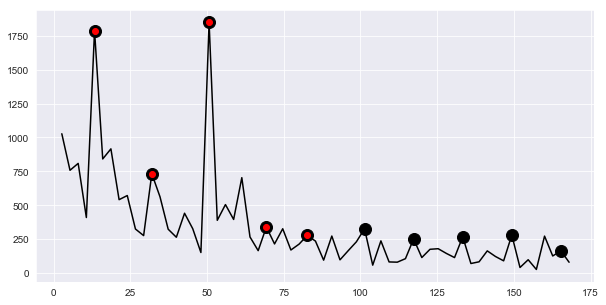

In [253]:
fig = plt.figure(figsize=(10,5))
plt.plot(f_values[1:], fft_values[1:], 'k')

plt.plot(xM, yM, 'o', color='k', markersize=12)
plt.plot(xF, yF, 'o', color='r', markersize=6)

Testiamo il funzionamento anche con le altre feature

In [254]:
xPSD, yPSD = extract_buffer_feats(ndf, buffer_index=88, process='PSD')

In [255]:
xPSD, yPSD

(array([ 13.12335958,  34.12073491,  49.8687664 ,  81.3648294 ,
        123.35958005]),
 array([520181.8325147 , 111761.58176693, 547194.61753155,  22268.4775136 ,
         13504.1227187 ]))

In [256]:
f_values, psd_values = welch(ndf.reindex([88]), fs=f, nperseg=N)

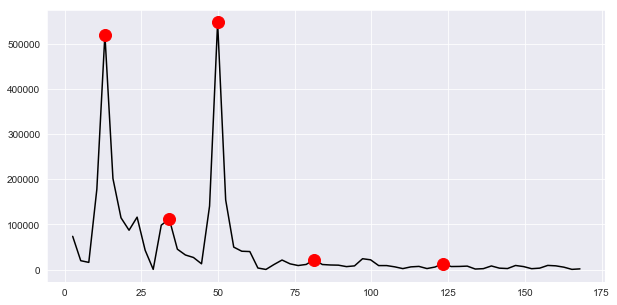

In [257]:
fig = plt.figure(figsize=(10,5))
plt.plot(f_values[1:], np.ravel(psd_values)[1:], 'k')
plt.plot(xPSD, yPSD, 'o', c='r', ms=12)

In [258]:
xaCorr, yaCorr = extract_buffer_feats(ndf, buffer_index=88, process='aCorr')

In [259]:
xaCorr, yaCorr

(array([0.01785938, 0.03869531, 0.05953125, 0.08036719, 0.09822656]),
 array([2.44519961e+08, 2.03009654e+07, 3.99569958e+08, 2.90916414e+08,
        1.18019227e+08]))

In [260]:
result = np.correlate(ndf.reindex([88]).squeeze(),
                      ndf.reindex([88]).squeeze(), mode='full')
autocorr_values = result[result.size//2:]
t_values = np.array([T * jj for jj in range(0, N)])

In [261]:
peaks_ind, _ = find_peaks(np.ravel(autocorr_values), threshold=None, distance=5)

In [262]:
xaCorrM, yaCorrM = t_values[peaks_ind], autocorr_values[peaks_ind]

In [263]:
xaCorrM, yaCorrM

(array([0.01785938, 0.03869531, 0.05953125, 0.08036719, 0.09822656,
        0.12203906, 0.13989844, 0.16073438, 0.17859375, 0.19942969,
        0.22026562, 0.238125  , 0.25896094, 0.27979688, 0.29765625,
        0.31253906, 0.34230469, 0.36016406]),
 array([ 2.44519961e+08,  2.03009654e+07,  3.99569958e+08,  2.90916414e+08,
         1.18019227e+08,  1.93991622e+08,  1.53562299e+08,  2.26160128e+08,
         8.91993126e+07, -1.93851495e+07,  1.61454025e+08,  1.38288986e+08,
        -7.23346585e+07,  4.16228275e+07,  5.04348887e+07, -1.49059748e+07,
         3.23692470e+07,  5.68323722e+07]))

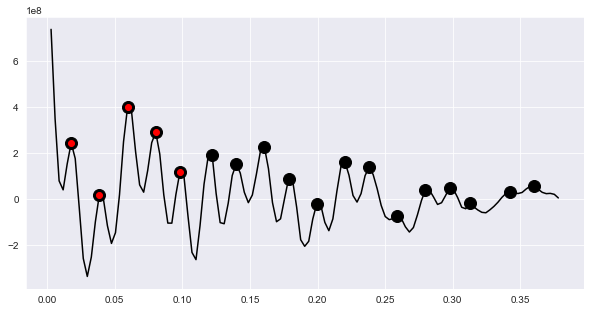

In [264]:
fig = plt.figure(figsize=(10,5))
plt.plot(t_values[1:], np.ravel(autocorr_values)[1:], 'k')
plt.plot(xaCorrM, yaCorrM, 'o', color='k', ms=12)
plt.plot(xaCorr, yaCorr, 'o', color='r', ms=6)

Dai plot si evidenzia anche che occorrerà settare i parametri per l'estrazione dei picchi in base al tipo di trasformazione effettuata.

Costruiamo ora il df con le feature estratte per la variabile x.

In [265]:
# Definiamo i nomi delle colonne delle feature
a = ("FFT_ " * 10).split(" ")[:-1]
b = ("peak_ " * 10).split(" ")[:-1]
c = list(np.ravel([[e]*2 for e in range(1,6)]))
d = ["_freq", "_amp"]*5
col_names_FFT = [w+x+str(y)+z+"_x_" for w,x,y,z in zip(a,b,c,d)]

In [266]:
col_names_FFT

['FFT_peak_1_freq_x_',
 'FFT_peak_1_amp_x_',
 'FFT_peak_2_freq_x_',
 'FFT_peak_2_amp_x_',
 'FFT_peak_3_freq_x_',
 'FFT_peak_3_amp_x_',
 'FFT_peak_4_freq_x_',
 'FFT_peak_4_amp_x_',
 'FFT_peak_5_freq_x_',
 'FFT_peak_5_amp_x_']

In [267]:
traindf.head()

0         1         2          3         4         5       6  \
0 -5632.000 -3633.333 -1634.667    364.000  5018.000  9672.000  9672.0   
1 -7852.571 -7810.857 -7769.143  -7727.429 -7685.714 -7644.000 -5444.0   
2 -7988.000 -7348.000 -6708.000  -6068.000 -6862.667 -7657.333 -8452.0   
3  4116.000  1548.000 -1020.000  -3588.000  -613.333  2361.333  5336.0   
4  -856.000 -2650.000 -4444.000  10036.000  1150.000 -7736.000 -7736.0   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -3244.000 -1044.000  -857.714  ...   -3572.000 -3572.000 -1546.667   
2 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
3  3317.333  1298.667  -720.000  ...   -6672.000 -6825.231 -6978.462   
4 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   

        122       123        124        125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.000 -7030.667 -7509.333      1  
1   478.667  2504.000    234.667  -2034.667 -4304.000   -94.000      1  
2  3178.667  6997.333  10816.000  10816.000  1336.000 -8144.000      1  
3 -7131.692 -7284.923  -7438.154  -7591.385 -7744.615 -7897.846      1  
4 -6312.000 -3896.000  -1480.000  -1480.000  1512.000  1512.000      1  

[5 rows x 129 columns]

In [268]:
ndf = traindf.drop(['label'], axis=1)
list_of_feat_lists = []

for i in range(0,ndf.shape[0]):
    
    x, y = extract_buffer_feats(ndf, i, 'FFT', peaks_interval=7)
    freqs_amps_lst = list(zip(x, y))
    list_of_feat_lists.append(np.ravel(freqs_amps_lst))

x_FFT_feat_data = pd.DataFrame(list_of_feat_lists, columns=col_names_FFT)
x_FFT_feat_data.fillna(0, inplace=True)

In [269]:
x_FFT_feat_data.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0            7.000000        3255.000000           50.000000   
1           10.665333        3596.414590           29.329667   
2            7.999000        3233.046352           31.996000   
3            7.999000        2663.325108           31.996000   
4           10.665333        1334.432730           31.996000   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0        2221.000000           69.000000         690.000000   
1         915.077337           50.660334        2695.204850   
2        1185.575239           50.660334        3190.958328   
3         868.850931           50.660334        3472.609816   
4        1030.454527           50.660334        2167.468466   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0          151.000000         184.000000            0.000000   
1           74.657334         886.288779          146.648336   
2           69.324668         889.961313           98.654335   
3           69.324668         580.180709          101.320668   
4           87.989001         806.151901          111.986002   

   FFT_peak_5_amp_x_  
0           0.000000  
1         346.599550  
2         999.281909  
3        1382.131236  
4         154.564261

In [270]:
x_FFT_feat_data.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
1280            7.999000         609.665738           29.329667   
1281           10.665333         518.823040           29.329667   
1282            7.999000         580.054606           29.329667   
1283           21.330667         463.433478           50.660334   
1284            5.332667         764.769543           50.660334   

      FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
1280         265.686204           50.660334         828.842952   
1281         249.317658           50.660334         893.783808   
1282         233.046753           50.660334         824.639613   
1283         897.920457           77.323668         338.246411   
1284        1070.878519           77.323668         352.022272   

      FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
1280           69.324668         182.032591           93.321668   
1281           69.324668         228.979995          101.320668   
1282           77.323668         183.265178           98.654335   
1283           95.988001         140.800053          127.984002   
1284           98.654335         238.037827          122.651335   

      FFT_peak_5_amp_x_  
1280         134.606590  
1281         164.577450  
1282         210.128167  
1283          83.570922  
1284         135.358389

In [271]:
a = ("PSD_ " * 10).split(" ")[:-1]
b = ("peak_ " * 10).split(" ")[:-1]
c = list(np.ravel([[e]*2 for e in range(1,6)]))
d = ["_freq", "_amp"]*5
col_names_PSD = [w+x+str(y)+z+"_x_" for w,x,y,z in zip(a,b,c,d)]

In [272]:
col_names_PSD

['PSD_peak_1_freq_x_',
 'PSD_peak_1_amp_x_',
 'PSD_peak_2_freq_x_',
 'PSD_peak_2_amp_x_',
 'PSD_peak_3_freq_x_',
 'PSD_peak_3_amp_x_',
 'PSD_peak_4_freq_x_',
 'PSD_peak_4_amp_x_',
 'PSD_peak_5_freq_x_',
 'PSD_peak_5_amp_x_']

In [273]:
ndf = traindf.drop(['label'], axis=1)
list_of_feat_lists = []

for i in range(0,ndf.shape[0]):
    
    x, y = extract_buffer_feats(ndf, i, 'PSD', peaks_interval=5)
    freqs_amps_lst = list(zip(x, y))
    list_of_feat_lists.append(np.ravel(freqs_amps_lst))

x_PSD_feat_data = pd.DataFrame(list_of_feat_lists, columns=col_names_PSD)
x_PSD_feat_data.fillna(0, inplace=True)

In [274]:
x_PSD_feat_data.head()

PSD_peak_1_freq_x_  PSD_peak_1_amp_x_  PSD_peak_2_freq_x_  \
0            7.000000       2.440941e+06           23.000000   
1           10.000000       3.321245e+06           36.000000   
2            2.624672       5.337414e+05           20.997375   
3            7.874016       1.200005e+06           36.745407   
4            2.000000       1.949976e+06           49.000000   

   PSD_peak_2_amp_x_  PSD_peak_3_freq_x_  PSD_peak_3_amp_x_  \
0      400850.000000           49.000000       4.256800e+05   
1      491507.000000           49.000000       1.035452e+06   
2      172672.698639           49.868766       1.219637e+06   
3      217318.755561           49.868766       2.456431e+06   
4      286200.000000            0.000000       0.000000e+00   

   PSD_peak_4_freq_x_  PSD_peak_4_amp_x_  PSD_peak_5_freq_x_  \
0            0.000000           0.000000            0.000000   
1           73.000000       73950.000000            0.000000   
2           68.241470      188293.106776           97.112861   
3           86.614173      245677.511379           99.737533   
4            0.000000           0.000000            0.000000   

   PSD_peak_5_amp_x_  
0           0.000000  
1           0.000000  
2      171970.864639  
3      444574.064595  
4           0.000000

In [275]:
x_PSD_feat_data.tail()

PSD_peak_1_freq_x_  PSD_peak_1_amp_x_  PSD_peak_2_freq_x_  \
1280            7.874016       69481.594173           23.622047   
1281            5.000000       21488.000000           26.000000   
1282            7.874016       37785.334777           23.622047   
1283            7.874016       57532.871923           28.871391   
1284            5.249344       63321.294052           18.372703   

      PSD_peak_2_amp_x_  PSD_peak_3_freq_x_  PSD_peak_3_amp_x_  \
1280       55052.240554           49.868766       78665.150111   
1281       11774.000000           49.000000       74790.000000   
1282        8895.931953           49.868766      156757.869234   
1283       33313.623816           49.868766       71469.197043   
1284       17249.143834           31.496063       27611.277467   

      PSD_peak_4_freq_x_  PSD_peak_4_amp_x_  PSD_peak_5_freq_x_  \
1280           62.992126        8650.313759           91.863517   
1281           68.000000        4279.000000            0.000000   
1282           65.616798       10707.804832          115.485564   
1283           76.115486       16065.462093          152.230971   
1284           49.868766      157579.930091           97.112861   

      PSD_peak_5_amp_x_  
1280        1203.043386  
1281           0.000000  
1282        4973.771490  
1283        3426.631752  
1284        7179.324544

In [276]:
a = ("aCorr_ " * 10).split(" ")[:-1]
b = ("peak_ " * 10).split(" ")[:-1]
c = list(np.ravel([[e]*2 for e in range(1,6)]))
d = ["_freq", "_amp"]*5
col_names_aCorr = [w+x+str(y)+z+"_x_" for w,x,y,z in zip(a,b,c,d)]

In [277]:
col_names_aCorr

['aCorr_peak_1_freq_x_',
 'aCorr_peak_1_amp_x_',
 'aCorr_peak_2_freq_x_',
 'aCorr_peak_2_amp_x_',
 'aCorr_peak_3_freq_x_',
 'aCorr_peak_3_amp_x_',
 'aCorr_peak_4_freq_x_',
 'aCorr_peak_4_amp_x_',
 'aCorr_peak_5_freq_x_',
 'aCorr_peak_5_amp_x_']

In [278]:
ndf = traindf.drop(['label'], axis=1)
list_of_feat_lists = []

for i in range(0,ndf.shape[0]):
    
    x, y = extract_buffer_feats(ndf, i, 'aCorr', peaks_interval=10)
    freqs_amps_lst = list(zip(x, y))
    list_of_feat_lists.append(np.ravel(freqs_amps_lst))

x_aCorr_feat_data = pd.DataFrame(list_of_feat_lists, columns=col_names_aCorr)
x_aCorr_feat_data.fillna(0, inplace=True)

In [279]:
x_aCorr_feat_data.head()

aCorr_peak_1_freq_x_  aCorr_peak_1_amp_x_  aCorr_peak_2_freq_x_  \
0              0.023813         1.137003e+09              0.080367   
1              0.017859         1.224400e+09              0.080367   
2              0.020836         1.465125e+09              0.059531   
3              0.020836         1.649673e+09              0.059531   
4              0.020836         1.493364e+09              0.059531   

   aCorr_peak_2_amp_x_  aCorr_peak_3_freq_x_  aCorr_peak_3_amp_x_  \
0         2.631446e+08              0.122039         5.155692e+08   
1         1.118327e+09              0.119063         6.026774e+08   
2         1.694524e+08              0.119063         5.790109e+08   
3         5.412282e+08              0.101203         6.635194e+08   
4         7.544048e+08              0.095250         1.748665e+08   

   aCorr_peak_4_freq_x_  aCorr_peak_4_amp_x_  aCorr_peak_5_freq_x_  \
0              0.157758        -1.892888e+08              0.214313   
1              0.160734        -1.399396e+08              0.199430   
2              0.157758         4.186433e+08              0.217289   
3              0.139898         5.916408e+08              0.181570   
4              0.178594         2.936906e+08              0.217289   

   aCorr_peak_5_amp_x_  
0         4.309260e+08  
1         4.447695e+08  
2         1.442064e+08  
3         4.843047e+07  
4         2.212893e+08

In [280]:
x_aCorr_feat_data.tail()

aCorr_peak_1_freq_x_  aCorr_peak_1_amp_x_  aCorr_peak_2_freq_x_  \
1280              0.020836         8.344569e+07              0.059531   
1281              0.020836         1.037486e+08              0.080367   
1282              0.020836         1.204220e+08              0.080367   
1283              0.038695         1.213393e+08              0.101203   
1284              0.038695         1.635533e+08              0.080367   

      aCorr_peak_2_amp_x_  aCorr_peak_3_freq_x_  aCorr_peak_3_amp_x_  \
1280         6.724880e+07              0.119063         9.740600e+07   
1281         4.436457e+07              0.119063         3.923600e+07   
1282         7.018245e+07              0.119063         8.465533e+07   
1283         9.354591e+07              0.136922         7.544385e+07   
1284         9.251420e+07              0.142875         1.100551e+08   

      aCorr_peak_4_freq_x_  aCorr_peak_4_amp_x_  aCorr_peak_5_freq_x_  \
1280              0.175617         7.249310e+07              0.217289   
1281              0.160734         4.147627e+07              0.199430   
1282              0.157758         5.036482e+07              0.217289   
1283              0.196453         8.178129e+07              0.238125   
1284              0.199430         8.347474e+07              0.241102   

      aCorr_peak_5_amp_x_  
1280         4.266363e+07  
1281         5.714906e+07  
1282         6.645681e+07  
1283         7.032367e+07  
1284         6.637564e+07

Concateniamo orizzontalmente i dataframe ottenuti.

In [281]:
x_data = pd.concat([x_FFT_feat_data, x_PSD_feat_data, x_aCorr_feat_data], axis=1)

In [283]:
x_data.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0            7.000000        3255.000000           50.000000   
1           10.665333        3596.414590           29.329667   
2            7.999000        3233.046352           31.996000   
3            7.999000        2663.325108           31.996000   
4           10.665333        1334.432730           31.996000   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0        2221.000000           69.000000         690.000000   
1         915.077337           50.660334        2695.204850   
2        1185.575239           50.660334        3190.958328   
3         868.850931           50.660334        3472.609816   
4        1030.454527           50.660334        2167.468466   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0          151.000000         184.000000            0.000000   
1           74.657334         886.288779          146.648336   
2           69.324668         889.961313           98.654335   
3           69.324668         580.180709          101.320668   
4           87.989001         806.151901          111.986002   

   FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_x_  \
0           0.000000         ...                       0.023813   
1         346.599550         ...                       0.017859   
2         999.281909         ...                       0.020836   
3        1382.131236         ...                       0.020836   
4         154.564261         ...                       0.020836   

   aCorr_peak_1_amp_x_  aCorr_peak_2_freq_x_  aCorr_peak_2_amp_x_  \
0         1.137003e+09              0.080367         2.631446e+08   
1         1.224400e+09              0.080367         1.118327e+09   
2         1.465125e+09              0.059531         1.694524e+08   
3         1.649673e+09              0.059531         5.412282e+08   
4         1.493364e+09              0.059531         7.544048e+08   

   aCorr_peak_3_freq_x_  aCorr_peak_3_amp_x_  aCorr_peak_4_freq_x_  \
0              0.122039         5.155692e+08              0.157758   
1              0.119063         6.026774e+08              0.160734   
2              0.119063         5.790109e+08              0.157758   
3              0.101203         6.635194e+08              0.139898   
4              0.095250         1.748665e+08              0.178594   

   aCorr_peak_4_amp_x_  aCorr_peak_5_freq_x_  aCorr_peak_5_amp_x_  
0        -1.892888e+08              0.214313         4.309260e+08  
1        -1.399396e+08              0.199430         4.447695e+08  
2         4.186433e+08              0.217289         1.442064e+08  
3         5.916408e+08              0.181570         4.843047e+07  
4         2.936906e+08              0.217289         2.212893e+08  

[5 rows x 30 columns]

In [284]:
x_data.shape

(1285, 30)

In [285]:
def name_feat_cols(list_of_processes, var):
    
    
    """
    data una lista di processi di trasformazione del segnale
    e variabili, estrae una lista di nomi delle colonne per
    il df delle feature
    
    parametri :
    -----------
    list_of_processes : str list, nomi dei processi di trasformazione
    var : str, variabile della trasformata
    
    return :
    --------
    process_col_names : str list, nomi delle feature
    
    """
    
    process_col_names = []
    
    for p in list_of_processes:

        a = ((str(p) + "_ ") * 10).split(" ")[:-1]
        b = ("peak_ " * 10).split(" ")[:-1]
        c = list(np.ravel([[e]*2 for e in range(1,6)]))
        d = ["_freq", "_amp"]*5
        feat_col_names = [w+x+str(y)+z+"_"+var+"_" for w,x,y,z in zip(a,b,c,d)]
        process_col_names.append(feat_col_names)
    
    process_col_names = np.ravel(process_col_names)
    
    return process_col_names

In [286]:
def extract_feat(df, process, var, threshold_rate=0.01, npeaks=5, peaks_interval=5):
    
    """
    Estrae le feature dal segnale suddiviso in buffer utilizzando
    un tipo di trasformazione (process) secondo i parametri definiti,
    per la variabile selezionata (var)
    
    
    parametri :
    -----------
    df : pandas DataFrame del segnale diviso in buffer di n campioni
    process : str, tipo di trasformazione
                   {'FFT': Fast Fourier Transform,
                    'PSD': Power Spectral Density,
                    'aCorr': Autocorrelation Index}
    var : str, variabile da processare
    threshold_rate : float in [0,1], default 0.01
                     coefficiente che consente di settare una soglia verticale
                     per la scelta dei picchi (più è grande, minore è l'ampiezza
                     di soglia che regola la selezione dei picchi più "bassi")
    npeaks : int, numero di picchi (feature) da estrarre
    peaks_interval : int, intervallo minimo tra due picchi consecutivi
    
    return:
    -------
    feat_data : pandas DataFrame contenente le feature estratte in base al
                processo di trasformazione per la variabile scelta del
                segnale diviso in buffer                
    
    """
    process_name = [process]
    process_col_names = name_feat_cols(process_name, var)
    
    if df.columns[-1] == 'label':
        
        df = df.drop(['label'], axis=1)
    
    list_of_feat_lists = []

    for i in range(0, df.shape[0]):

        x, y = extract_buffer_feats(df, i, process, threshold_rate, npeaks, peaks_interval)
        freqs_amps_lst = list(zip(x, y))
        list_of_feat_lists.append(np.ravel(freqs_amps_lst))
    
    feat_data = pd.DataFrame(list_of_feat_lists, columns=process_col_names)
    feat_data.fillna(0, inplace=True)
    
    return feat_data

In [287]:
name_feat_cols(['FFT'], 'x')

array(['FFT_peak_1_freq_x_', 'FFT_peak_1_amp_x_', 'FFT_peak_2_freq_x_',
       'FFT_peak_2_amp_x_', 'FFT_peak_3_freq_x_', 'FFT_peak_3_amp_x_',
       'FFT_peak_4_freq_x_', 'FFT_peak_4_amp_x_', 'FFT_peak_5_freq_x_',
       'FFT_peak_5_amp_x_'], dtype='<U18')

In [288]:
traindf.head()

0         1         2          3         4         5       6  \
0 -5632.000 -3633.333 -1634.667    364.000  5018.000  9672.000  9672.0   
1 -7852.571 -7810.857 -7769.143  -7727.429 -7685.714 -7644.000 -5444.0   
2 -7988.000 -7348.000 -6708.000  -6068.000 -6862.667 -7657.333 -8452.0   
3  4116.000  1548.000 -1020.000  -3588.000  -613.333  2361.333  5336.0   
4  -856.000 -2650.000 -4444.000  10036.000  1150.000 -7736.000 -7736.0   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -3244.000 -1044.000  -857.714  ...   -3572.000 -3572.000 -1546.667   
2 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
3  3317.333  1298.667  -720.000  ...   -6672.000 -6825.231 -6978.462   
4 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   

        122       123        124        125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.000 -7030.667 -7509.333      1  
1   478.667  2504.000    234.667  -2034.667 -4304.000   -94.000      1  
2  3178.667  6997.333  10816.000  10816.000  1336.000 -8144.000      1  
3 -7131.692 -7284.923  -7438.154  -7591.385 -7744.615 -7897.846      1  
4 -6312.000 -3896.000  -1480.000  -1480.000  1512.000  1512.000      1  

[5 rows x 129 columns]

In [289]:
df = extract_feat(traindf, process='FFT', peaks_interval=7, var='x')

In [290]:
df.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0            7.000000        3255.000000           50.000000   
1           10.665333        3596.414590           29.329667   
2            7.999000        3233.046352           31.996000   
3            7.999000        2663.325108           31.996000   
4           10.665333        1334.432730           31.996000   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0        2221.000000           69.000000         690.000000   
1         915.077337           50.660334        2695.204850   
2        1185.575239           50.660334        3190.958328   
3         868.850931           50.660334        3472.609816   
4        1030.454527           50.660334        2167.468466   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0          151.000000         184.000000            0.000000   
1           74.657334         886.288779          146.648336   
2           69.324668         889.961313           98.654335   
3           69.324668         580.180709          101.320668   
4           87.989001         806.151901          111.986002   

   FFT_peak_5_amp_x_  
0           0.000000  
1         346.599550  
2         999.281909  
3        1382.131236  
4         154.564261

In [291]:
pi_dict = {'FFT':7, 'PSD':5, 'aCorr':10}

In [292]:
list_of_processes = ['FFT', 'PSD', 'aCorr']

In [293]:
def extract_all_feats_for_var(dataset_type, var, peaks_interval_dict, threshold_rate=0.01, npeaks=5):

    """
    Estrae le feature dal segnale suddiviso in buffer utilizzando
    tutti i tipi di trasformazione (process) secondo i parametri definiti,
    per la variabile selezionata (var). Il dataset è direttamente estratto
    dalle directory di input in base al tipo (train o test).
    Per ottenere le feature, parametri di soglia (threshold_rate),
    numero di picchi (npeaks) e intervallo tra i picchi (peaks_interval_dic)
    possono essere passati come argomenti
        
    parametri :
    -----------
    dataset_type : str, tipo di dati da cui estrarre le feat ["train", "test"]
    var : str, variabile da processare
    threshold_rate : float in [0,1], default 0.01
                     coefficiente che consente di settare una soglia verticale
                     per la scelta dei picchi (più è grande, minore è l'ampiezza
                     di soglia che regola la selezione dei picchi più "bassi")
    npeaks : int, numero di picchi (feature) da estrarre
    peaks_interval_dict : dict, definisce l'intervallo tra i picchi per ogni
                          tipo di trasformata
                          (ex.: peaks_interval_dict = {'FFT':7, 'PSD':5, 'aCorr':10})
                          
    
    return:
    -------
    data : pandas DataFrame contenente tutte le feature estratte
                per la variabile scelta del segnale diviso in buffer                
    
    """
           
    if dataset_type == "train":
        
        data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"
        mode = "_train_"
        
    elif dataset_type == "test":
        
        data_path = os.getcwd() + "\\data\\INPUT_TEST\\"
        mode = "_test_"
        
    else:
        
        print("Dataset type is not valid!\n")
        print("Types available are: 'train', 'test'. Enter a valid type.")
        return False
        
    windowed_signal = pd.read_csv(data_path + "windowed_signal" + mode + var + "_.csv", sep=",")

    list_of_dfs = []

    for process in list_of_processes:
        
        peaks_interval = peaks_interval_dict[process]
        df = extract_feat(windowed_signal, process, var, threshold_rate, npeaks, peaks_interval)
        list_of_dfs.append(df)

    data = pd.concat(list_of_dfs, axis=1)
    
    return data

In [294]:
data = extract_all_feats_for_var(dataset_type="train", var='x', peaks_interval_dict=pi_dict)

In [295]:
data.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0            7.000000        3255.000000           50.000000   
1           10.665333        3596.414590           29.329667   
2            7.999000        3233.046352           31.996000   
3            7.999000        2663.325108           31.996000   
4           10.665333        1334.432730           31.996000   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0        2221.000000           69.000000         690.000000   
1         915.077337           50.660334        2695.204850   
2        1185.575239           50.660334        3190.958328   
3         868.850931           50.660334        3472.609816   
4        1030.454527           50.660334        2167.468466   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0          151.000000         184.000000            0.000000   
1           74.657334         886.288779          146.648336   
2           69.324668         889.961313           98.654335   
3           69.324668         580.180709          101.320668   
4           87.989001         806.151901          111.986002   

   FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_x_  \
0           0.000000         ...                       0.023813   
1         346.599550         ...                       0.017859   
2         999.281909         ...                       0.020836   
3        1382.131236         ...                       0.020836   
4         154.564261         ...                       0.020836   

   aCorr_peak_1_amp_x_  aCorr_peak_2_freq_x_  aCorr_peak_2_amp_x_  \
0         1.137003e+09              0.080367         2.631446e+08   
1         1.224400e+09              0.080367         1.118327e+09   
2         1.465125e+09              0.059531         1.694524e+08   
3         1.649673e+09              0.059531         5.412282e+08   
4         1.493364e+09              0.059531         7.544048e+08   

   aCorr_peak_3_freq_x_  aCorr_peak_3_amp_x_  aCorr_peak_4_freq_x_  \
0              0.122039         5.155692e+08              0.157758   
1              0.119063         6.026774e+08              0.160734   
2              0.119063         5.790109e+08              0.157758   
3              0.101203         6.635194e+08              0.139898   
4              0.095250         1.748665e+08              0.178594   

   aCorr_peak_4_amp_x_  aCorr_peak_5_freq_x_  aCorr_peak_5_amp_x_  
0        -1.892888e+08              0.214313         4.309260e+08  
1        -1.399396e+08              0.199430         4.447695e+08  
2         4.186433e+08              0.217289         1.442064e+08  
3         5.916408e+08              0.181570         4.843047e+07  
4         2.936906e+08              0.217289         2.212893e+08  

[5 rows x 30 columns]

In [296]:
data.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
1280            7.999000         609.665738           29.329667   
1281           10.665333         518.823040           29.329667   
1282            7.999000         580.054606           29.329667   
1283           21.330667         463.433478           50.660334   
1284            5.332667         764.769543           50.660334   

      FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
1280         265.686204           50.660334         828.842952   
1281         249.317658           50.660334         893.783808   
1282         233.046753           50.660334         824.639613   
1283         897.920457           77.323668         338.246411   
1284        1070.878519           77.323668         352.022272   

      FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
1280           69.324668         182.032591           93.321668   
1281           69.324668         228.979995          101.320668   
1282           77.323668         183.265178           98.654335   
1283           95.988001         140.800053          127.984002   
1284           98.654335         238.037827          122.651335   

      FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_x_  \
1280         134.606590         ...                       0.020836   
1281         164.577450         ...                       0.020836   
1282         210.128167         ...                       0.020836   
1283          83.570922         ...                       0.038695   
1284         135.358389         ...                       0.038695   

      aCorr_peak_1_amp_x_  aCorr_peak_2_freq_x_  aCorr_peak_2_amp_x_  \
1280         8.344569e+07              0.059531         6.724880e+07   
1281         1.037486e+08              0.080367         4.436457e+07   
1282         1.204220e+08              0.080367         7.018245e+07   
1283         1.213393e+08              0.101203         9.354591e+07   
1284         1.635533e+08              0.080367         9.251420e+07   

      aCorr_peak_3_freq_x_  aCorr_peak_3_amp_x_  aCorr_peak_4_freq_x_  \
1280              0.119063         9.740600e+07              0.175617   
1281              0.119063         3.923600e+07              0.160734   
1282              0.119063         8.465533e+07              0.157758   
1283              0.136922         7.544385e+07              0.196453   
1284              0.142875         1.100551e+08              0.199430   

      aCorr_peak_4_amp_x_  aCorr_peak_5_freq_x_  aCorr_peak_5_amp_x_  
1280         7.249310e+07              0.217289         4.266363e+07  
1281         4.147627e+07              0.199430         5.714906e+07  
1282         5.036482e+07              0.217289         6.645681e+07  
1283         8.178129e+07              0.238125         7.032367e+07  
1284         8.347474e+07              0.241102         6.637564e+07  

[5 rows x 30 columns]

Applichiamo la funzione di estrazione dei picchi per tutti i processi per la singola variabile a tutte le variabili per ottenere il dataset finale di training e test, salvandoli in altrettanti file csv.

In [297]:
dataset_type = "train"
variables = ['x', 'y', 'z']
peaks_interval_dict = {'FFT':7, 'PSD':5, 'aCorr':10}
list_of_processes = ['FFT', 'PSD', 'aCorr']

list_of_var_dfs = []

for var in variables:
    
    data_var = extract_all_feats_for_var(dataset_type, var, peaks_interval_dict)
    list_of_var_dfs.append(data_var)
    
all_data_TRAIN = pd.concat(list_of_var_dfs, axis=1)

In [298]:
all_data_TRAIN.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0            7.000000        3255.000000           50.000000   
1           10.665333        3596.414590           29.329667   
2            7.999000        3233.046352           31.996000   
3            7.999000        2663.325108           31.996000   
4           10.665333        1334.432730           31.996000   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0        2221.000000           69.000000         690.000000   
1         915.077337           50.660334        2695.204850   
2        1185.575239           50.660334        3190.958328   
3         868.850931           50.660334        3472.609816   
4        1030.454527           50.660334        2167.468466   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0          151.000000         184.000000            0.000000   
1           74.657334         886.288779          146.648336   
2           69.324668         889.961313           98.654335   
3           69.324668         580.180709          101.320668   
4           87.989001         806.151901          111.986002   

   FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
0           0.000000         ...                       0.026789   
1         346.599550         ...                       0.038695   
2         999.281909         ...                       0.020836   
3        1382.131236         ...                       0.020836   
4         154.564261         ...                       0.020836   

   aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
0         6.683115e+08              0.056555         3.816076e+08   
1        -3.558012e+08              0.098227         5.109961e+08   
2         9.017758e+08              0.059531        -7.965508e+07   
3         8.503428e+08              0.059531         1.243238e+08   
4         3.824669e+08              0.056555         1.022504e+08   

   aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
0              0.107156         6.078750e+08              0.157758   
1              0.163711        -8.067936e+07              0.202406   
2              0.116086         3.402783e+08              0.157758   
3              0.101203         4.010208e+08              0.130969   
4              0.095250        -1.251130e+08              0.160734   

   aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
0        -1.827127e+07              0.214313         5.067535e+08  
1         2.439597e+08              0.238125         1.545373e+08  
2         4.632624e+08              0.199430        -4.045086e+07  
3         2.178403e+08              0.160734         4.475898e+08  
4        -2.201302e+07              0.196453         1.669705e+08  

[5 rows x 90 columns]

In [299]:
all_data_TRAIN.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
1280            7.999000         609.665738           29.329667   
1281           10.665333         518.823040           29.329667   
1282            7.999000         580.054606           29.329667   
1283           21.330667         463.433478           50.660334   
1284            5.332667         764.769543           50.660334   

      FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
1280         265.686204           50.660334         828.842952   
1281         249.317658           50.660334         893.783808   
1282         233.046753           50.660334         824.639613   
1283         897.920457           77.323668         338.246411   
1284        1070.878519           77.323668         352.022272   

      FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
1280           69.324668         182.032591           93.321668   
1281           69.324668         228.979995          101.320668   
1282           77.323668         183.265178           98.654335   
1283           95.988001         140.800053          127.984002   
1284           98.654335         238.037827          122.651335   

      FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
1280         134.606590         ...                       0.017859   
1281         164.577450         ...                       0.020836   
1282         210.128167         ...                       0.020836   
1283          83.570922         ...                       0.020836   
1284         135.358389         ...                       0.020836   

      aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
1280         3.079093e+08              0.059531         2.206368e+08   
1281         3.380139e+08              0.059531         2.586133e+08   
1282         3.187376e+08              0.059531         2.826439e+08   
1283         2.918740e+08              0.059531         2.792707e+08   
1284         3.421169e+08              0.080367         2.725458e+08   

      aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
1280              0.119063         2.470443e+08              0.157758   
1281              0.098227         2.503031e+08              0.139898   
1282              0.119063         2.232621e+08              0.160734   
1283              0.098227         2.285801e+08              0.157758   
1284              0.119063         2.517253e+08              0.178594   

      aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
1280         1.681783e+08              0.199430         1.557877e+08  
1281         2.090048e+08              0.178594         1.903892e+08  
1282         2.203891e+08              0.220266         1.421674e+08  
1283         2.102921e+08              0.199430         1.655158e+08  
1284         1.804212e+08              0.217289         1.490478e+08  

[5 rows x 90 columns]

In [300]:
all_data_TRAIN.shape

(1285, 90)

In [301]:
all_data_TRAIN.columns

Index(['FFT_peak_1_freq_x_', 'FFT_peak_1_amp_x_', 'FFT_peak_2_freq_x_',
       'FFT_peak_2_amp_x_', 'FFT_peak_3_freq_x_', 'FFT_peak_3_amp_x_',
       'FFT_peak_4_freq_x_', 'FFT_peak_4_amp_x_', 'FFT_peak_5_freq_x_',
       'FFT_peak_5_amp_x_', 'PSD_peak_1_freq_x_', 'PSD_peak_1_amp_x_',
       'PSD_peak_2_freq_x_', 'PSD_peak_2_amp_x_', 'PSD_peak_3_freq_x_',
       'PSD_peak_3_amp_x_', 'PSD_peak_4_freq_x_', 'PSD_peak_4_amp_x_',
       'PSD_peak_5_freq_x_', 'PSD_peak_5_amp_x_', 'aCorr_peak_1_freq_x_',
       'aCorr_peak_1_amp_x_', 'aCorr_peak_2_freq_x_', 'aCorr_peak_2_amp_x_',
       'aCorr_peak_3_freq_x_', 'aCorr_peak_3_amp_x_', 'aCorr_peak_4_freq_x_',
       'aCorr_peak_4_amp_x_', 'aCorr_peak_5_freq_x_', 'aCorr_peak_5_amp_x_',
       'FFT_peak_1_freq_y_', 'FFT_peak_1_amp_y_', 'FFT_peak_2_freq_y_',
       'FFT_peak_2_amp_y_', 'FFT_peak_3_freq_y_', 'FFT_peak_3_amp_y_',
       'FFT_peak_4_freq_y_', 'FFT_peak_4_amp_y_', 'FFT_peak_5_freq_y_',
       'FFT_peak_5_amp_y_', 'PSD_peak_1_freq_y_', 

In [302]:
os.getcwd()

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine'

In [303]:
train_data_path = os.getcwd() + '\\data\\INPUT_TRAIN\\'
train_data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\'

In [304]:
all_data_TRAIN.to_csv(train_data_path + "DATA_TRAIN.csv", sep=",",
                      index=False, float_format='%.3f', encoding='utf-8')

Ripetiamo gli step per il test set.

In [305]:
dataset_type = "test"
variables = ['x', 'y', 'z']
peaks_interval_dict = {'FFT':7, 'PSD':5, 'aCorr':10}
list_of_processes = ['FFT', 'PSD', 'aCorr']

list_of_var_dfs = []

for var in variables:
    
    data_var = extract_all_feats_for_var(dataset_type, var, peaks_interval_dict)
    list_of_var_dfs.append(data_var)
    
all_data_TEST = pd.concat(list_of_var_dfs, axis=1)

In [306]:
all_data_TEST.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0            7.999000        3288.533776           39.995001   
1            7.999000        3471.030421           39.995001   
2           18.664334        1637.025536           50.660334   
3            7.999000        4438.885671           26.663334   
4            7.999000        3522.635739           31.996000   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0        1770.276765           58.659334         758.342909   
1        2065.053351           66.658334         652.831936   
2        3343.399979           79.990001         511.559786   
3         898.030888           50.660334        3672.511266   
4        1037.042494           50.660334        2527.628472   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0           98.654335         719.449719          130.650335   
1           98.654335        1165.472632          130.650335   
2          101.320668        1123.618728          130.650335   
3           74.657334         651.140420          103.987002   
4           77.323668         287.402443           98.654335   

   FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
0         527.387340         ...                       0.020836   
1         817.960335         ...                       0.020836   
2         723.028434         ...                       0.038695   
3         965.262068         ...                       0.080367   
4         697.865770         ...                       0.017859   

   aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
0         4.062501e+08              0.050602        -2.948626e+08   
1         4.406506e+08              0.053578        -2.478187e+08   
2        -4.077534e+08              0.080367         6.332930e+08   
3         9.049540e+07              0.122039         5.053339e+08   
4         7.605098e+08              0.059531        -1.064014e+08   

   aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
0              0.101203         3.963829e+08              0.151805   
1              0.101203         4.043151e+08              0.154781   
2              0.139898        -1.867160e+08              0.181570   
3              0.163711         3.176481e+08              0.205383   
4              0.101203         6.079593e+08              0.139898   

   aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
0        -1.161907e+07              0.181570        -1.040584e+07  
1         2.732690e+08              0.184547        -1.848071e+08  
2         4.130753e+08              0.220266         2.417276e+08  
3        -4.029032e+08              0.261937         6.793370e+08  
4         1.434840e+08              0.199430         1.926497e+08  

[5 rows x 90 columns]

In [307]:
all_data_TEST.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
540            5.332667         804.798328           31.996000   
541           10.665333         413.661362           31.996000   
542           21.330667         601.269173           50.660334   
543           10.665333         740.857715           29.329667   
544           10.665333        1086.876187           31.996000   

     FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
540         671.538127           50.660334         952.509713   
541         232.425790           50.660334         744.796253   
542         859.835309           69.324668         171.438273   
543         409.294389           50.660334        1018.138974   
544         372.657230           50.660334        1081.968994   

     FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
540           71.991001         222.408140           98.654335   
541           79.990001         160.015835          101.320668   
542           95.988001          77.485699          122.651335   
543           82.656335         214.184179          114.652335   
544           98.654335         259.989919          117.318668   

     FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
540         243.157194         ...                       0.020836   
541         160.332699         ...                       0.017859   
542          36.033413         ...                       0.017859   
543          94.268428         ...                       0.017859   
544         241.213319         ...                       0.017859   

     aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
540         3.867564e+08              0.080367         3.324809e+08   
541         2.827346e+08              0.059531         2.471536e+08   
542         2.850697e+08              0.056555         2.424987e+08   
543         2.560628e+08              0.059531         1.372731e+08   
544         2.984682e+08              0.080367         2.553501e+08   

     aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
540              0.119063         2.438176e+08              0.157758   
541              0.098227         1.622006e+08              0.136922   
542              0.098227         1.878236e+08              0.139898   
543              0.098227         2.238999e+08              0.136922   
544              0.119063         1.837328e+08              0.178594   

     aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
540         2.174834e+08              0.217289         1.980876e+08  
541         1.842873e+08              0.178594         1.234864e+08  
542         1.767570e+08              0.178594         1.591092e+08  
543         1.269066e+08              0.199430         1.500468e+08  
544         1.866545e+08              0.217289         7.290218e+07  

[5 rows x 90 columns]

In [308]:
all_data_TEST.shape

(545, 90)

In [309]:
all_data_TEST.columns

Index(['FFT_peak_1_freq_x_', 'FFT_peak_1_amp_x_', 'FFT_peak_2_freq_x_',
       'FFT_peak_2_amp_x_', 'FFT_peak_3_freq_x_', 'FFT_peak_3_amp_x_',
       'FFT_peak_4_freq_x_', 'FFT_peak_4_amp_x_', 'FFT_peak_5_freq_x_',
       'FFT_peak_5_amp_x_', 'PSD_peak_1_freq_x_', 'PSD_peak_1_amp_x_',
       'PSD_peak_2_freq_x_', 'PSD_peak_2_amp_x_', 'PSD_peak_3_freq_x_',
       'PSD_peak_3_amp_x_', 'PSD_peak_4_freq_x_', 'PSD_peak_4_amp_x_',
       'PSD_peak_5_freq_x_', 'PSD_peak_5_amp_x_', 'aCorr_peak_1_freq_x_',
       'aCorr_peak_1_amp_x_', 'aCorr_peak_2_freq_x_', 'aCorr_peak_2_amp_x_',
       'aCorr_peak_3_freq_x_', 'aCorr_peak_3_amp_x_', 'aCorr_peak_4_freq_x_',
       'aCorr_peak_4_amp_x_', 'aCorr_peak_5_freq_x_', 'aCorr_peak_5_amp_x_',
       'FFT_peak_1_freq_y_', 'FFT_peak_1_amp_y_', 'FFT_peak_2_freq_y_',
       'FFT_peak_2_amp_y_', 'FFT_peak_3_freq_y_', 'FFT_peak_3_amp_y_',
       'FFT_peak_4_freq_y_', 'FFT_peak_4_amp_y_', 'FFT_peak_5_freq_y_',
       'FFT_peak_5_amp_y_', 'PSD_peak_1_freq_y_', 

In [310]:
os.getcwd()

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine'

In [311]:
test_data_path = os.getcwd() + '\\data\\INPUT_TEST\\'
test_data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\'

In [312]:
all_data_TEST.to_csv(test_data_path + "DATA_TEST.csv", sep=",",
                     index=False, float_format='%.3f', encoding='utf-8')

Infine, estraiamo le label per il training e per il test.

In [313]:
def extract_labels(dataset_type, var_list):
    
    """
    estrae le label per il train o per il test set come pandas df
    a partire dai file csv del segnale diviso per buffer di n sample
    per ciascuna variabile, e le salva in un file csv nelle dir LABELS
    
    parametri :
    -----------
    dataset_type : str, tipo di dataset, "train" o "test"
    var_list : str list, lista delle variabili utilizzate
    
    """
    
    if dataset_type == "train":
        
        data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"
        mode = "_train_"
        
    elif dataset_type == "test":
        
        data_path = os.getcwd() + "\\data\\INPUT_TEST\\"
        mode = "_test_"
        
    else:
        
        print("Dataset type is not valid!\n")
        print("Types available are: 'train', 'test'. Enter a valid type.")
        return False
    
    
    all_labels = []
    
    for var in var_list:
        
        signal = pd.read_csv(data_path + "windowed_signal" + mode + var + "_.csv", sep=",")
        all_labels.append(signal['label'])
    
    # verifica che i file csv contenenti il segnale per ciascuna variabile
    # abbiano la stessa sequenza di label
    if all(col.all() == all_labels[0].all() for col in all_labels):
        
        labels_df = pd.DataFrame(all_labels[0], columns=['label'])
    
    labels_type = dataset_type.upper()
    labels_path = os.getcwd() + "\\data\\LABELS_" + dataset_type.upper() +"\\"
    
    labels_df.to_csv(labels_path + "LABELS_" + labels_type + ".csv", sep=",",
                     index=False)

In [314]:
extract_labels(dataset_type="train", var_list=['x', 'y', 'z'])

In [315]:
extract_labels(dataset_type="test", var_list=['x', 'y', 'z'])

Testiamo le operazioni di salvataggio dei dataset finali.

In [330]:
data_path = os.getcwd() + "\\data\\"
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\'

In [331]:
train_data_path = data_path + "INPUT_TRAIN\\"
train_data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\'

In [332]:
train_labels_path = data_path + "LABELS_TRAIN\\"
train_labels_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\LABELS_TRAIN\\'

In [333]:
test_data_path = data_path + "INPUT_TEST\\"
test_data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TEST\\'

In [334]:
test_labels_path = data_path + "LABELS_TEST\\"
test_labels_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\LABELS_TEST\\'

In [340]:
train_df = pd.read_csv(train_data_path + "DATA_TRAIN.csv")
train_df.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0               7.000           3255.000              50.000   
1              10.665           3596.415              29.330   
2               7.999           3233.046              31.996   
3               7.999           2663.325              31.996   
4              10.665           1334.433              31.996   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0           2221.000               69.00            690.000   
1            915.077               50.66           2695.205   
2           1185.575               50.66           3190.958   
3            868.851               50.66           3472.610   
4           1030.455               50.66           2167.468   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0             151.000            184.000               0.000   
1              74.657            886.289             146.648   
2              69.325            889.961              98.654   
3              69.325            580.181             101.321   
4              87.989            806.152             111.986   

   FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
0              0.000         ...                          0.027   
1            346.600         ...                          0.039   
2            999.282         ...                          0.021   
3           1382.131         ...                          0.021   
4            154.564         ...                          0.021   

   aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
0         6.683115e+08                 0.057         3.816076e+08   
1        -3.558012e+08                 0.098         5.109961e+08   
2         9.017758e+08                 0.060        -7.965508e+07   
3         8.503428e+08                 0.060         1.243238e+08   
4         3.824669e+08                 0.057         1.022504e+08   

   aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
0                 0.107         6.078750e+08                 0.158   
1                 0.164        -8.067936e+07                 0.202   
2                 0.116         3.402783e+08                 0.158   
3                 0.101         4.010208e+08                 0.131   
4                 0.095        -1.251130e+08                 0.161   

   aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
0        -1.827127e+07                 0.214         5.067535e+08  
1         2.439597e+08                 0.238         1.545373e+08  
2         4.632624e+08                 0.199        -4.045086e+07  
3         2.178403e+08                 0.161         4.475898e+08  
4        -2.201302e+07                 0.196         1.669705e+08  

[5 rows x 90 columns]

In [341]:
train_df.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
1280               7.999            609.666               29.33   
1281              10.665            518.823               29.33   
1282               7.999            580.055               29.33   
1283              21.331            463.433               50.66   
1284               5.333            764.770               50.66   

      FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
1280            265.686              50.660            828.843   
1281            249.318              50.660            893.784   
1282            233.047              50.660            824.640   
1283            897.920              77.324            338.246   
1284           1070.879              77.324            352.022   

      FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
1280              69.325            182.033              93.322   
1281              69.325            228.980             101.321   
1282              77.324            183.265              98.654   
1283              95.988            140.800             127.984   
1284              98.654            238.038             122.651   

      FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
1280            134.607         ...                          0.018   
1281            164.577         ...                          0.021   
1282            210.128         ...                          0.021   
1283             83.571         ...                          0.021   
1284            135.358         ...                          0.021   

      aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
1280         3.079093e+08                  0.06         2.206368e+08   
1281         3.380139e+08                  0.06         2.586133e+08   
1282         3.187376e+08                  0.06         2.826439e+08   
1283         2.918740e+08                  0.06         2.792707e+08   
1284         3.421169e+08                  0.08         2.725458e+08   

      aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
1280                 0.119         2.470443e+08                 0.158   
1281                 0.098         2.503031e+08                 0.140   
1282                 0.119         2.232621e+08                 0.161   
1283                 0.098         2.285801e+08                 0.158   
1284                 0.119         2.517253e+08                 0.179   

      aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
1280         1.681783e+08                 0.199         1.557877e+08  
1281         2.090048e+08                 0.179         1.903892e+08  
1282         2.203891e+08                 0.220         1.421674e+08  
1283         2.102921e+08                 0.199         1.655158e+08  
1284         1.804212e+08                 0.217         1.490478e+08  

[5 rows x 90 columns]

In [336]:
train_df.shape

(1285, 90)

In [338]:
train_labels_df = pd.read_csv(train_labels_path + "LABELS_TRAIN.csv")
train_labels_df.head()

label
0      1
1      1
2      1
3      1
4      1

In [342]:
train_labels_df.tail()

label
1280      7
1281      7
1282      7
1283      7
1284      7

In [354]:
train_labels_df.shape

(1285, 1)

In [345]:
train_with_labels_df = pd.concat([train_df, train_labels_df], axis=1)

In [346]:
train_with_labels_df.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0               7.000           3255.000              50.000   
1              10.665           3596.415              29.330   
2               7.999           3233.046              31.996   
3               7.999           2663.325              31.996   
4              10.665           1334.433              31.996   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0           2221.000               69.00            690.000   
1            915.077               50.66           2695.205   
2           1185.575               50.66           3190.958   
3            868.851               50.66           3472.610   
4           1030.455               50.66           2167.468   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0             151.000            184.000               0.000   
1              74.657            886.289             146.648   
2              69.325            889.961              98.654   
3              69.325            580.181             101.321   
4              87.989            806.152             111.986   

   FFT_peak_5_amp_x_  ...    aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  \
0              0.000  ...           6.683115e+08                 0.057   
1            346.600  ...          -3.558012e+08                 0.098   
2            999.282  ...           9.017758e+08                 0.060   
3           1382.131  ...           8.503428e+08                 0.060   
4            154.564  ...           3.824669e+08                 0.057   

   aCorr_peak_2_amp_z_  aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  \
0         3.816076e+08                 0.107         6.078750e+08   
1         5.109961e+08                 0.164        -8.067936e+07   
2        -7.965508e+07                 0.116         3.402783e+08   
3         1.243238e+08                 0.101         4.010208e+08   
4         1.022504e+08                 0.095        -1.251130e+08   

   aCorr_peak_4_freq_z_  aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  \
0                 0.158        -1.827127e+07                 0.214   
1                 0.202         2.439597e+08                 0.238   
2                 0.158         4.632624e+08                 0.199   
3                 0.131         2.178403e+08                 0.161   
4                 0.161        -2.201302e+07                 0.196   

   aCorr_peak_5_amp_z_  label  
0         5.067535e+08      1  
1         1.545373e+08      1  
2        -4.045086e+07      1  
3         4.475898e+08      1  
4         1.669705e+08      1  

[5 rows x 91 columns]

In [347]:
train_with_labels_df.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
1280               7.999            609.666               29.33   
1281              10.665            518.823               29.33   
1282               7.999            580.055               29.33   
1283              21.331            463.433               50.66   
1284               5.333            764.770               50.66   

      FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
1280            265.686              50.660            828.843   
1281            249.318              50.660            893.784   
1282            233.047              50.660            824.640   
1283            897.920              77.324            338.246   
1284           1070.879              77.324            352.022   

      FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
1280              69.325            182.033              93.322   
1281              69.325            228.980             101.321   
1282              77.324            183.265              98.654   
1283              95.988            140.800             127.984   
1284              98.654            238.038             122.651   

      FFT_peak_5_amp_x_  ...    aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  \
1280            134.607  ...           3.079093e+08                  0.06   
1281            164.577  ...           3.380139e+08                  0.06   
1282            210.128  ...           3.187376e+08                  0.06   
1283             83.571  ...           2.918740e+08                  0.06   
1284            135.358  ...           3.421169e+08                  0.08   

      aCorr_peak_2_amp_z_  aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  \
1280         2.206368e+08                 0.119         2.470443e+08   
1281         2.586133e+08                 0.098         2.503031e+08   
1282         2.826439e+08                 0.119         2.232621e+08   
1283         2.792707e+08                 0.098         2.285801e+08   
1284         2.725458e+08                 0.119         2.517253e+08   

      aCorr_peak_4_freq_z_  aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  \
1280                 0.158         1.681783e+08                 0.199   
1281                 0.140         2.090048e+08                 0.179   
1282                 0.161         2.203891e+08                 0.220   
1283                 0.158         2.102921e+08                 0.199   
1284                 0.179         1.804212e+08                 0.217   

      aCorr_peak_5_amp_z_  label  
1280         1.557877e+08      7  
1281         1.903892e+08      7  
1282         1.421674e+08      7  
1283         1.655158e+08      7  
1284         1.490478e+08      7  

[5 rows x 91 columns]

In [349]:
# test per missing values (NaN)
(train_with_labels_df.isna().sum()).sum()

0

In [350]:
test_df = pd.read_csv(test_data_path + "DATA_TEST.csv")
test_df.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0               7.999           3288.534              39.995   
1               7.999           3471.030              39.995   
2              18.664           1637.026              50.660   
3               7.999           4438.886              26.663   
4               7.999           3522.636              31.996   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0           1770.277              58.659            758.343   
1           2065.053              66.658            652.832   
2           3343.400              79.990            511.560   
3            898.031              50.660           3672.511   
4           1037.042              50.660           2527.628   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0              98.654            719.450             130.650   
1              98.654           1165.473             130.650   
2             101.321           1123.619             130.650   
3              74.657            651.140             103.987   
4              77.324            287.402              98.654   

   FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
0            527.387         ...                          0.021   
1            817.960         ...                          0.021   
2            723.028         ...                          0.039   
3            965.262         ...                          0.080   
4            697.866         ...                          0.018   

   aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
0         4.062501e+08                 0.051        -2.948626e+08   
1         4.406506e+08                 0.054        -2.478187e+08   
2        -4.077534e+08                 0.080         6.332930e+08   
3         9.049540e+07                 0.122         5.053339e+08   
4         7.605098e+08                 0.060        -1.064014e+08   

   aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
0                 0.101         3.963829e+08                 0.152   
1                 0.101         4.043151e+08                 0.155   
2                 0.140        -1.867160e+08                 0.182   
3                 0.164         3.176481e+08                 0.205   
4                 0.101         6.079593e+08                 0.140   

   aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
0        -1.161907e+07                 0.182        -1.040584e+07  
1         2.732690e+08                 0.185        -1.848071e+08  
2         4.130753e+08                 0.220         2.417276e+08  
3        -4.029032e+08                 0.262         6.793370e+08  
4         1.434840e+08                 0.199         1.926497e+08  

[5 rows x 90 columns]

In [353]:
test_df.shape

(545, 90)

In [351]:
test_labels_df = pd.read_csv(test_labels_path + "LABELS_TEST.csv")
test_labels_df.head()

label
0      1
1      1
2      1
3      1
4      1

In [352]:
test_labels_df.tail()

label
540      7
541      7
542      7
543      7
544      7

In [355]:
test_labels_df.shape

(545, 1)

In [356]:
test_with_labels_df = pd.concat([test_df, test_labels_df], axis=1)

In [357]:
test_with_labels_df.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0               7.999           3288.534              39.995   
1               7.999           3471.030              39.995   
2              18.664           1637.026              50.660   
3               7.999           4438.886              26.663   
4               7.999           3522.636              31.996   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0           1770.277              58.659            758.343   
1           2065.053              66.658            652.832   
2           3343.400              79.990            511.560   
3            898.031              50.660           3672.511   
4           1037.042              50.660           2527.628   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0              98.654            719.450             130.650   
1              98.654           1165.473             130.650   
2             101.321           1123.619             130.650   
3              74.657            651.140             103.987   
4              77.324            287.402              98.654   

   FFT_peak_5_amp_x_  ...    aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  \
0            527.387  ...           4.062501e+08                 0.051   
1            817.960  ...           4.406506e+08                 0.054   
2            723.028  ...          -4.077534e+08                 0.080   
3            965.262  ...           9.049540e+07                 0.122   
4            697.866  ...           7.605098e+08                 0.060   

   aCorr_peak_2_amp_z_  aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  \
0        -2.948626e+08                 0.101         3.963829e+08   
1        -2.478187e+08                 0.101         4.043151e+08   
2         6.332930e+08                 0.140        -1.867160e+08   
3         5.053339e+08                 0.164         3.176481e+08   
4        -1.064014e+08                 0.101         6.079593e+08   

   aCorr_peak_4_freq_z_  aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  \
0                 0.152        -1.161907e+07                 0.182   
1                 0.155         2.732690e+08                 0.185   
2                 0.182         4.130753e+08                 0.220   
3                 0.205        -4.029032e+08                 0.262   
4                 0.140         1.434840e+08                 0.199   

   aCorr_peak_5_amp_z_  label  
0        -1.040584e+07      1  
1        -1.848071e+08      1  
2         2.417276e+08      1  
3         6.793370e+08      1  
4         1.926497e+08      1  

[5 rows x 91 columns]

In [358]:
test_with_labels_df.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
540               5.333            804.798              31.996   
541              10.665            413.661              31.996   
542              21.331            601.269              50.660   
543              10.665            740.858              29.330   
544              10.665           1086.876              31.996   

     FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
540            671.538              50.660            952.510   
541            232.426              50.660            744.796   
542            859.835              69.325            171.438   
543            409.294              50.660           1018.139   
544            372.657              50.660           1081.969   

     FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
540              71.991            222.408              98.654   
541              79.990            160.016             101.321   
542              95.988             77.486             122.651   
543              82.656            214.184             114.652   
544              98.654            259.990             117.319   

     FFT_peak_5_amp_x_  ...    aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  \
540            243.157  ...           3.867564e+08                 0.080   
541            160.333  ...           2.827346e+08                 0.060   
542             36.033  ...           2.850697e+08                 0.057   
543             94.268  ...           2.560628e+08                 0.060   
544            241.213  ...           2.984682e+08                 0.080   

     aCorr_peak_2_amp_z_  aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  \
540         3.324809e+08                 0.119         2.438176e+08   
541         2.471536e+08                 0.098         1.622006e+08   
542         2.424987e+08                 0.098         1.878236e+08   
543         1.372731e+08                 0.098         2.238999e+08   
544         2.553501e+08                 0.119         1.837328e+08   

     aCorr_peak_4_freq_z_  aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  \
540                 0.158         2.174834e+08                 0.217   
541                 0.137         1.842873e+08                 0.179   
542                 0.140         1.767570e+08                 0.179   
543                 0.137         1.269066e+08                 0.199   
544                 0.179         1.866545e+08                 0.217   

     aCorr_peak_5_amp_z_  label  
540         1.980876e+08      7  
541         1.234864e+08      7  
542         1.591092e+08      7  
543         1.500468e+08      7  
544         7.290218e+07      7  

[5 rows x 91 columns]

In [359]:
# test per missing values (NaN)
(test_with_labels_df.isna().sum()).sum()

0